# Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization

A notebook by 10037, 10071 and 10076.

## Contents
* [Introduction](#intro)
* [Theory behind methods](#method)
* [Analyzing the CryptoPunks dataset](#dataset)
* [Denoising](#denoising)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

The field of machine learning have in the last two decades showed itself able to solve many problems that up to this point was unpractical or unsolvable for humans. Before the advent of the quite effective nonlinear methods (i.e., neural networks), clever use of linear algebra made it possible to analyze and compress large datasets if the problem at hand had a certain linearity. 

One of these linear approaches is the Non-negative Matrix Factorization or NMF. In this notebook, we will explore the use of NMF on images from the CryptoPunks dataset. This dataset contains around 10k computer-generated NFT's of pixelated faces wearing different accessories. A consequence of these faces being computer generated, and the main reason we are using this dataset, is that features and accessories that appear in multiple pictures (i.e., the same-colored sunglasses appear on multiple NFT's) have the same pixel-position on every image. This should, at least in theory, make it possible to write an image as a linear combination of features, and may result in compression or dimensionality reduction. 

As a method of dimensionality reduction, one could argue that the Singular Value Decomposition yields a more accurate reconstruction than imposing the condition of non-negativity. However, writing an image as a linear combination of features that are non-negative, gives us the opportunity to show the 'vectors' as images. As it turns out, these vectors correspond to features easily discerned by humans, giving a powerful insight into the most important aspects of the dataset. 

Another use of NMF is noise-reduction. To express random noise as linear combinations, one would need many 'vectors', as large amounts of information are needed to represent high entropy features such as noise. With this feature-based approach, one should therefore expect the most dominant to prevail when constricting the number of features. 

We will begin by discussing some theory about NMF, including an explanation of the algorithm we will use to compute them. With a working NMF-algorithm, we will thereafter analyze the CryptoPunk dataset and try to remove (computer-generated) noise from the images. 

A note on the runtimes in this notebook: Some of the cells in this notebook has a very long runtime. We saved data to external files and loaded it back into our notebook on each run. Feel free to uncomment any code and run it for yourself to get the files needed to recreate our plots, but some of the simulations have runtimes approaching 20h.

Below we import the libraries needed for this project. 

In [1]:
# Libraries for math and plotting
import numpy as np
import matplotlib.pyplot as plt

## Image handling, files, timing and status bar
#%pip install opencv-python 
# Required to import cv2 !!!
import cv2
import os
import time

# Gives a progress bar 
from tqdm.notebook import tqdm

# Used to combine saved images
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

To reduce the amount of lines required to make plots, and avoid copying similar code to many cells, we create a standard plot function.

In [2]:
def plot_function(x_vals_list, y_vals_list, linestyles, shape = False, fig_size = (15, 5), 
    xlabels = ["" for i in range(20)], ylabels = ["" for i in range(20)],
    fig_text = False, fig_text_size = 15, fig_text_y = -0.04, 
    title_size = 15, titles = ["" for i in range(20)], 
    label_size = 15, labels = [False for i in range(20)], loc = ["upper right" for i in range(20)]):
    """
    Plotfunction for generating subplots with shape of choise. 
    input: 
        x_vals_list: List of lists of np.arrays of x values
        y_vals_list: List of lists of np.arrays of y values
        linestyles:  List of lists of linestyles for each subplot
        + Various other matplotlib keyword arguments.
    output:
        None. Plot is shown below codeblock.
    """
    # Create fig, axs
    if not shape:
        shape = (1, len(x_vals_list)) # Set default shape
    fig, axs = plt.subplots(shape[0], shape[1], figsize=fig_size)
        
    # Make axs iterable if only 1
    if len(x_vals_list) == 1:
        axs = [axs]
    
    # Reshape to 1D list of ax if grid-shaped to ease iterations
    if shape[0] != 1 and shape[1] != 1:
        axs = [axs[i//shape[0], i%shape[0]] for i in range(shape[0]*shape[1])]

    # Loop and plot
    for i, (ax, x, y) in enumerate(zip(axs, x_vals_list, y_vals_list)):
        for xvals, yvals, style in zip(x, y, linestyles[i]):
            ax.plot(xvals, yvals, style)
        ax.set_title(titles[i], size = title_size)
        if labels[i]:
            ax.legend(labels[i], loc=loc[i], prop={'size': label_size-2})
        ax.set_xlabel(xlabels[i], size = label_size)
        ax.set_ylabel(ylabels[i], size = label_size)
    
    # Add centred figure-text below figure
    if fig_text:
        plt.figtext(0.5, fig_text_y, fig_text, wrap=True, horizontalalignment='center', fontsize = fig_text_size)
    
    plt.show()

## Theory behind methods <a class="anchor" id="method"></a>


Non-negative matrix factorization (NMF) is a method for reducing the dimension of matrices, given by: 

$$A ≈ A_{NMF} = W H.$$

Where $A$ is a $m\,\times\,n$ matrix that we want to reduce the dimensionality of. $W$ is a non-negative $m\,\times\,d$ matrix and $H$ is a non-negative $d\,x\,n$ matrix. $d$ is usually chosen to be considerably smaller than $n$ and $m$, so that $A$ can be represented in a more compact manner, but if $d$ is too small it can lead to an inadequate approximation of $A$. We will refer to $A_{NMF}=WH$ as the reconstruction of $A$. We will refer to the columns of $W$ as features of the dataset and the rows of $H$ as the weights of these features. We shall see that NMF's can help us better understand a large dataset by breaking it down into distinct features. The NMF of $A$ satisfies:

$$\min_{W, H} \lVert A - WH \rVert_F,$$

such that $W$ and $H$ are non-negative. There are infinitely many combinations of $W$ and $H$ that satisfy this condition, meaning that the NMF is non-unique. This can be shown by considering the invertible $d\times d$ matrix $D$:

$$
\begin{align}
    A_{NMF} = WH = WD^{-1}DH.
\end{align}
$$

If our new matrices $WD^{-1}$ and $DH$ are non-negative and $D\ne I$ we have obtained a different NMF. In the simplest case we have $D=bI$ and $D^{-1}=\frac{1}{b}I$ for a $b>0, b\ne1$. This property will later be utilized to adjust $W$.

**The algorithm**

To calculate an NMF, we will use the algorithm proposed by D. Lee and H. A. Seung in "Advances in neural information processing systems (2001)":

$$
\begin{align}
H_{k+1} &← H_k \odot (W^T_k A) \oslash (W^T_k W_kH_k) \\
W_{k+1} &← W_k \odot (AH^T_{k+1}) \oslash (W_kH_{k+1}H^T_{k+1}).
\end{align}
$$

The operators $\odot$ and $\oslash$ returns a matrix where the corresponding elements the operator acts on are multiplied and divided respectively. The algorithm satisfies: 

$$\lVert A - W_{k+1}H_{k+1} \rVert_F \leqslant \lVert A - W_kH_k \rVert_F,$$

meaning that it converges to a local minimizer of the error, and therefore it may just find and approximate solution of the NMF, which again approximates $A$. As a result, there is a big room for error as the NMF might be a poor approximation of $A$ and our algorithm might not converge to a satisfying solution for the NMF.


**Non-negativity**

We will now show that if $A$ is non-negative and $W$ and $H$ are initialized as positive, then all iterates $W_k$ and $H_k$ are also positive. This will be done by induction.

Assume $A$ is non-negative (and non-zero, as this is not very interesting) and $W$ and $H$ are initialized as positive. Let $P(n)$ be the statement $W_n$ and $H_n$ are positive. The hypothesis clearly holds for the base case $P(0)$, as $W_0=W$ and $H_0=H$ being positive is part of our assumptions. Now we assume the induction hypothesis holds for $n=k$. We have that:
    
$$
\begin{align}
H_{k+1} &← H_k ⊙ (W^T_k A) ⊘ (W^T_k W_kH_k) \\
W_{k+1} &← W_k ⊙ (AH^T_{k+1}) ⊘ (W_kH_{k+1}H^T_{k+1}).
\end{align}
$$
    
It is clear that $H_{k+1}$ is positive, as it is a product of $H_k$, $W_k$, $W^T_k$ and $A$, which are all positive under our assumptions and induction hypothesis. It follows that $W_{k+1}$ is positive, as it is also a product of only positive matrices. Thus, the induction hypothesis holds for $n=k+1$. By induction it follows that $P(n)$ holds for all $n\in\mathbb{Z^+}$.


If either $W_0$ or $H_0$ are set to matrices containing only zeros, we can see from: 

$$
\begin{align}
H_{k+1} &← H_k \odot (W^T_k A) \oslash (W^T_k W_kH_k) \\
W_{k+1} &← W_k \odot (AH^T_{k+1}) \oslash (W_kH_{k+1}H^T_{k+1}).
\end{align}
$$ 

that $H_k$ and $W_k$ converges to $0$ regardless of $A$. In other words, $WH$ will never converge towards $A$, unless by chance $A$ is also a matrix of zeros. In our implementation we therefore randomize the initial values from the uniform distribution between 0 and $\sqrt{\textrm{mean}(A)/d}$.


**Fixed point of the algorithm**

If $(W^T_k A) ⊘ (W^T_k W_kH_k)$ is a matrix of ones we see that when calculating $H_{k+1}$ we multiply every element of $H_k$ by $1$, meaning $H_{k+1}=H_k$, this is known as a fixed point. This happens when $W_kH_k=A$:

$$(W^T_k A) ⊘ (W^T_k W_kH_k)=(W^T_k A) ⊘ (W^T_k A).$$

⊘ denotes elementwise division, so we are left with a matrix of the elements in $W^T_k A$ divided by themselves, which clearly is a matrix of ones.


**Implementation and testing**

We will now implement the NMF algorithm. To avoid division by 0 we will include a safe division constant $\delta$.

In [3]:
def NMF(A, d, delta=1e-9, maxiter=1000, seed=4269):
    """
    Performs maxiter iterations of the NMF algorithm described above to find 
    matrices W and H such that A ≈ WH. 
    input:
        A: (m,n) input array
        d: integer, Number of components we want to decompose A into
        delta: float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        err: array of length maxiter+1 with Frobenius norms ||A-WH||
    """
    # Set seed
    if seed != 0:
        np.random.seed(seed)
        
    # Find dimensions of A
    m = np.shape(A)[0]
    n = np.shape(A)[1]
    
    # Initialize W and H with numbers from Unif(0, 1), and rescale by factor sqrt(mean(A)/d)
    random_numbers_01 = np.random.uniform(0.0, 1.0, m*d+d*n) # we need m*d+d*n numbers
    W = np.sqrt(np.mean(A)/d) * random_numbers_01[0:m*d].reshape((m, d))
    H = np.sqrt(np.mean(A)/d) * random_numbers_01[m*d:m*d+d*n].reshape((d, n))

    # Initialize the array err for storing the Frobenius norm ||A-WH||
    err    = np.zeros(maxiter+1)
    err[0] = np.linalg.norm(A - np.dot(W, H), 'fro')
    
    # Perform the iterations
    for k in tqdm(range(maxiter), leave=False):
        H *= np.dot(W.T, A) / (np.dot(W.T, np.dot(W, H)) + delta)
        W *= np.dot(A, H.T) / (np.dot(W, np.dot(H, H.T)) + delta)
        err[k+1] = np.linalg.norm(A - np.dot(W, H), 'fro')
    
    return W, H, err

To test that our algorithm works we define the following matrices:

$$ 
A_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix},\,\,\,\,\,
A_2 = \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix},\,\,\,\,\,
A_3 = \begin{bmatrix} 2 & 1 & 1 \\ 2 & 1 & 1 \\ 1 & 1 & 2 \end{bmatrix},\,\,\,\,\,
A_4 = \begin{bmatrix} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end{bmatrix}.
$$

We begin by running the algorithm with $d=1$ for $A_1$ and $A_2$ for two different seeds.


In [4]:
A1 = np.array([[1, 0],
               [0, 1]], dtype = "float")

A2 = np.array([[1, 2],
               [1, 1],
               [1, 2]], dtype = "float")


def A1A2_test(seeds, d=1, dec=3, maxiter=1000):
    """
    Runs NMF algorithm for A1 and A2 with the seeds given in seeds and prints the results in a 
    readable format. 
    input:
        seeds: list of seeds to run NMF with
        d: int, number of features in W and
        dec: int, number of decimals in output
        maxiter: int, number of iterations for NMF
    output: 
        None. Results are printed.
    """
    # Iterate for A1
    for seed in seeds:
        W1, H1, err1 = NMF(A1, d, seed=seed, maxiter=maxiter)
        print(f"With A = A\u2081 =\n{np.round(A1, dec)}, \nwe find W = \n{np.round(W1, dec)},",
              f"\nH = \n{np.round(H1, dec)}, \nWH = \n{np.round(np.dot(W1, H1), dec)}.")
        print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err1[-1]}")
        print(100*"-")
        
    # Repeat for A2
    for seed in seeds:
        W2, H2, err2 = NMF(A2, d, seed = seed, maxiter=maxiter)
        print(f"With A = A\u2082 =\n{np.round(A2, dec)}, \nwe find W = \n{np.round(W2, dec)},",
              f"\nH = \n{np.round(H2, dec)}, \nWH = \n{np.round(np.dot(W2, H2), dec)}.")
        print(f"This gives the Frobenius norm ||A\u2082-WH|| = {err2[-1]}")

        print(100*"-")
    
## Run the test with two different seeds. Uncomment to verify the data in the table below.
seeds = [42, 69]
# A1A2_test(seeds)

*Table 1:* Results from the code above.

|                |        $A$        |       $W$       |       $H$       |       $WH$      |$\lVert{A-WH}\rVert_F$|
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| seed 1 | \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | \begin{bmatrix} 0.265 \\ 0.672 \end{bmatrix} | \begin{bmatrix} 0.507 & 1.288 \end{bmatrix} | \begin{bmatrix} 0.134 & 0.341 \\ 0.341 & 0.866 \end{bmatrix} | $1.0$ |  
| seed 2 |                                              | \begin{bmatrix} 0.209 \\ 0.572 \end{bmatrix} | \begin{bmatrix} 0.564 & 1.541 \end{bmatrix} | \begin{bmatrix} 0.118 & 0.323 \\ 0.323 & 0.882 \end{bmatrix} | $1.0$ 
| seed 1 | \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix} | \begin{bmatrix} 1.078 \\ 0.658 \\ 1.078 \end{bmatrix} | \begin{bmatrix} 1.021 & 1.803 \end{bmatrix} | \begin{bmatrix} 1.1 & 1.943 \\ 0.671 & 1.186 \\ 1.1 & 1.943 \end{bmatrix} | $0.411$ |
| seed 2 |                                               | \begin{bmatrix} 0.869 \\ 0.530 \\ 0.869 \end{bmatrix} | \begin{bmatrix} 1.266 & 2.236 \end{bmatrix} | \begin{bmatrix} 1.1 & 1.943 \\ 0.671 & 1.186 \\ 1.1 & 1.943 \end{bmatrix} | $0.411$ | 


From the table above we can see that $\lVert{A-WH}\rVert_F$ is the same for both seeds for matrix $A_1$ and $A_2$. Further we notice that $A_2$ produces the same reconstruction $WH$ for both seeds, even though the individual $W$ and $H$ matrices are different. Even though $A_1$ produces different $WH$ matrices for the two seeds the similarities between them are clear. Firstly, the elements of the matrices are close to each other in value. Secondly the lower left and upper right elements are equal in both matrices, while the two remaining elements are different to each other with the lower left being the largest. Generally, we notice that corresponding elements of $W$ and $H$ from the two different seeds are similar in size, and when the elements in $W$ are larger the values of its $H$ are smaller and vice versa. Note that these tendencies seem to be true in our case, but the selection is too small to draw any definite conclusion for all seeds and matrices.


In [5]:
## Calculate NMF of A1 and A2 with d = 2
# A1A2_test([4269], d = 2, dec = 3)


*Table 2:* Results from NMF with $d=2$.

|        $A$        |       $W$       |       $H$       |       $WH$      |$\lVert{A-WH}\rVert_F$|
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | \begin{bmatrix} 0.11 & 0 \\ 0 & 0.132 \end{bmatrix} | \begin{bmatrix} 9.109 & 0 \\ 0 & 7.567 \end{bmatrix} | \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | $1.718\cdot10^{-10}$ |  
| \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix} | \begin{bmatrix} 0.265 & 0.38 \\ 0.079 & 0.463 \\ 0.265 & 0.38 \end{bmatrix} | \begin{bmatrix} 0.892 & 5.871 \\ 2.007 & 1.163 \end{bmatrix} | \begin{bmatrix} 1 & 2 \\ 1 &  1 \\ 1 & 2 \end{bmatrix} | $6.589\cdot 10^{-10}$ |

With $d=2$ the Frobenius norm, $\lVert{A-WH}\rVert_F$, is close to $0$ for both matrices. This result is reasonable considering we are reconstructing $A_1$, which is $2x2$ matrix, by two $2x2$ matrices and $A_2$, a $2x3$ matrix, by a $3x2$ and $2x2$ matrix. Essentially, we are reconstructing the matrices using more data than they originally contained, and this results in a satisfying reconstruction. In this case the use of NMF is not very efficient as we end up using more data to represent our matrices.


In [6]:
A3 = np.array([[2, 1, 1],
               [2, 1, 1],
               [1, 1, 2]], dtype = "float")

A4 = np.array([[2, 1, 0],
               [1, 2, 3],
               [0, 3, 3]], dtype = "float")

# Print the space of eigenvalues for A3 and A4
print(f"\u03C3(A\u2083) = \u007b{np.linalg.eig(A3)[0][0]}, {np.linalg.eig(A3)[0][1]}, {np.linalg.eig(A3)[0][2]}\u007d")
print(f"\u03C3(A\u2084) = \u007b{np.linalg.eig(A4)[0][0]}, {np.linalg.eig(A4)[0][1]}, {np.linalg.eig(A4)[0][2]}\u007d\n")

# Verify the results with np.linalg.matrix_rank
print(f"np.linalg.matrix_rank(A3) returns {np.linalg.matrix_rank(A3)}")
print(f"np.linalg.matrix_rank(A4) returns {np.linalg.matrix_rank(A4)}")

σ(A₃) = {4.000000000000002, 1.0000000000000002, -5.063800617498565e-16}
σ(A₄) = {-0.7577017654507552, 2.0991149902691513, 5.658586775181606}

np.linalg.matrix_rank(A3) returns 2
np.linalg.matrix_rank(A4) returns 3


From the space of eigenvalues, $\sigma(A_3)$, we see that 0 is an eigenvalue of the matrix $A_3$. It only has two non-zero eigenvalues, and is therefore a rank $2$ matrix. $\sigma(A_4)$ shows that $A_4$ has three non-zero eigenvalues, so it is a rank 3 matrix.

**Convergence**

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

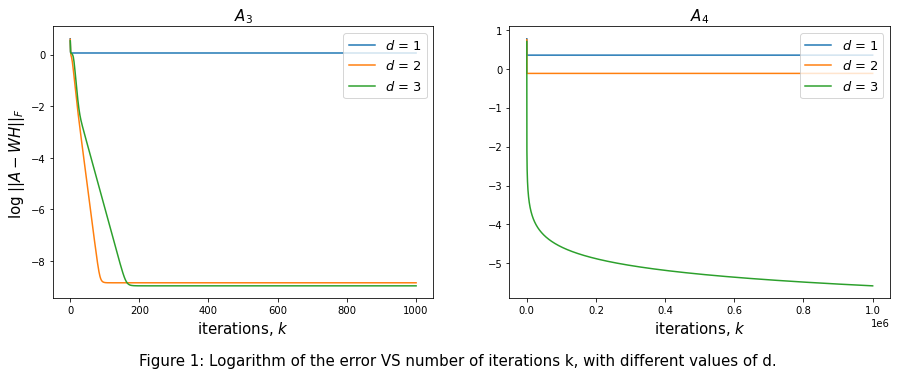

In [7]:
maxiters = [1000, 1000000]  # Max iterations for the two matrices
d_vals   = [1, 2, 3]        # Values for d
log_error_arrays = [[], []] # List of lists of error arrays for A3 and A4

# Iterate over d values and append corresponding error arrays
for d in d_vals:
    log_error_arrays[0].append(np.log10(NMF(A3, d, maxiter = maxiters[0])[2]))
    log_error_arrays[1].append(np.log10(NMF(A4, d, maxiter = maxiters[1])[2]))
    
# Create arrays for x-values (iterations), linestyles and define the figure text
x_vals_list = [[np.linspace(0, maxiters[j]+1, maxiters[j]+1) for i in range(3)] for j in range(2)]
linestyles  = [["tab:blue", "tab:orange", "tab:green"] for i in range(2)]
fig_text    = "Figure 1: Logarithm of the error VS number of iterations k, with different values of d."

plot_function(x_vals_list, log_error_arrays, linestyles, fig_size = (15, 5), 
        xlabels = [f"iterations, $k$", f"iterations, $k$"], ylabels = [r"log $||A-WH||_F$", ""],
        fig_text=fig_text, fig_text_y = -0.06, titles = [r"$A_3$", "$A_4$"], labels = [[f"$d$ = {d_vals[i]}" for i in range(3)] for j in range(2)])

<a class="anchor" id="figure_1"></a>

From the plots we see that the equation: 

$$\lVert A - W_{k+1}H_{k+1} \rVert_F \leqslant \lVert A - W_kH_k \rVert_F,$$ 

 seems to be satisfied, at least up to a thousand iterations. For both matrices and all values of $d$ the error rapidly decreases as the number of iterations k increase, for small values of k. When k grows past a certain value, the error starts to remain constant. This is because the algorithm has converged to a global or local minima. Because of the large number of iterations, it is likely that the minima is global. We can see that for some of our cases, like $A_3$ with $d=2$, the error converges to 0. Meaning the NMF is a perfect reconstruction of the original matrix.

However, running 1.000.000 iterations on $d=3$ shows that the algorithm doesn't really converge, but improves slowly over many iterations. For $d<3$ however, the algorithm converges rapidly.


We have now developed the tools necessary to begin exploring a larger dataset. 

## Analyzing the CryptoPunks dataset <a class="anchor" id="dataset"></a>

We will now turn our attention to a dataset consisting of 10 000 images of size $24\times24$ pixels. They are stored as RGBA images, meaning that each pixel has 4 values: red, green, blue and alpha. Alpha represents the opacity of the images. We will sample $N=500$ of the images. Towards the end of the project, we will briefly study the effect of decreasing and increasing $N$. We will use a unique but predetermined seed to ensure unique results that won't change by restarting the notebook. 

The load_images function was handed out but has been modified slightly to pick images before loading them into the notebook. The images are stored as a $24\times24\times4\times N$ numpy array.   


In [8]:
def load_images(N, seed = 4269):
    """
    Loads N random images from cryptopunk dataset. Use the same seed to get the same
    selection each time. 
    Input:
        integer: N, number of images to load
        integer: seed for random sampling
    Output:
        array: faces, (24,24,4,N) numpy array containing images
    """
    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Chose N random image numbers
    M = 10000 # number of images to choose from
    np.random.seed(seed)
    image_number_choice = np.random.choice(np.arange(0, M),N, replace = False)
        
    # Iterate over folders
    for i in range(len(image_number_choice)):
        im_path = f"./imgs/imgs/imgs/{image_number_choice[i]}.png"
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

    return faces

Below is handed-out code for plotting the images we have loaded. It is modified to add numbers to the images. We also define a function that can merge images. This is to get around jupyter notebooks limit of one attachment per markdown cell.

In [9]:
def plotimgs(imgs, nplot=8, rescale=False, filename=None, figsize=(16, 16), number_color="black", show=True):
    """
    Plots nplot*nplot images on a nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # Initialize subplots
    fig, axes = plt.subplots(nplot, nplot, figsize=figsize)

    # Set background color
    plt.gcf().set_facecolor("lightgrey")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        if nplot > 1:
            axes[i,j].axis('off')
        else:
            axes.axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            if nplot > 1:
                axes[i,j].imshow(scaled_img)
            else:
                axes.imshow(scaled_img)
        else:
            if nplot > 1:
                axes[i,j].imshow(imgs[:,:,:,idx])
            else:
                axes.imshow(imgs[:,:,:])
        
        # Add numbers to each image
        if nplot > 1 and number_color:
            axes[i, j].text(0, 4, f"{idx+1}", color=number_color, fontsize=20)

    # Tight layout so images will appear closer together
    plt.tight_layout()
    
    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)
    
    if show:
        plt.show()
    else:
        plt.close()

        
def plotimgs_merge(filetitles, merged_title, img_txt=["a)", "b)", "c)"]):
    """
    Plots images side by side. This lets us combine images and serves as a workaround to 
    jupyters limitation of one image attachment per markdown cell.
    input:
        filetitles: list of titles of images to plot, ".png" is added by the functions
        merge_title: string, file title of merged file, ".png" is added by the functions
        img_txt: list of strings, text to imclude above each image
    output:
        None, saves the file as merged_title.png
    """
    num_of_imgs = len(filetitles) # Number of images
    size = 1000 # Pixels along edge of one image staged for merge
    font = ImageFont.truetype("arial.ttf", int(50 * size/1000)) # Font. fontsize scaled by size

    # Load images
    images = [Image.open(filetitle + ".png") for filetitle in filetitles]
    
    # Resize and merge the images
    x_size = int(size*(1+1/20))*num_of_imgs + int(size*(1/20))
    y_size = int(size*(1+3/20)) # double space above for figtext
    
    # Create the image
    merged_Image = Image.new('RGB', (x_size, y_size), (250, 250, 250))
    for index, image in enumerate(images):
        # Resize image
        image = image.resize((size, size))
        
        # Place image in merged image
        x_coord = int(size*(1+1/20))*index + int(size*(1/20))
        y_coord = int(size*(2/20))
        merged_Image.paste(image, (x_coord, y_coord))
        
    # Add text above each image:
    draw = ImageDraw.Draw(merged_Image)
    for index, text in enumerate(img_txt):
        x_coord = int(size*(1/20) + size/2) + index*(size*(1+1/20)) - draw.textsize(text, font=font)[0]/2
        y_coord = int(size*(1/20)*1/2)
        draw.text((x_coord, y_coord), text, (0,0,0), font=font)
    
    # Save image
    merged_Image.save(merged_title,"PNG")

**First look at the dataset**

We now have all we need to investigate the dataset.

In [10]:
## Load N=500 images and create a plot of them
faces500 = load_images(500)
# plotimgs(faces500, nplot=8, filename="2a_punks.png")


<div>
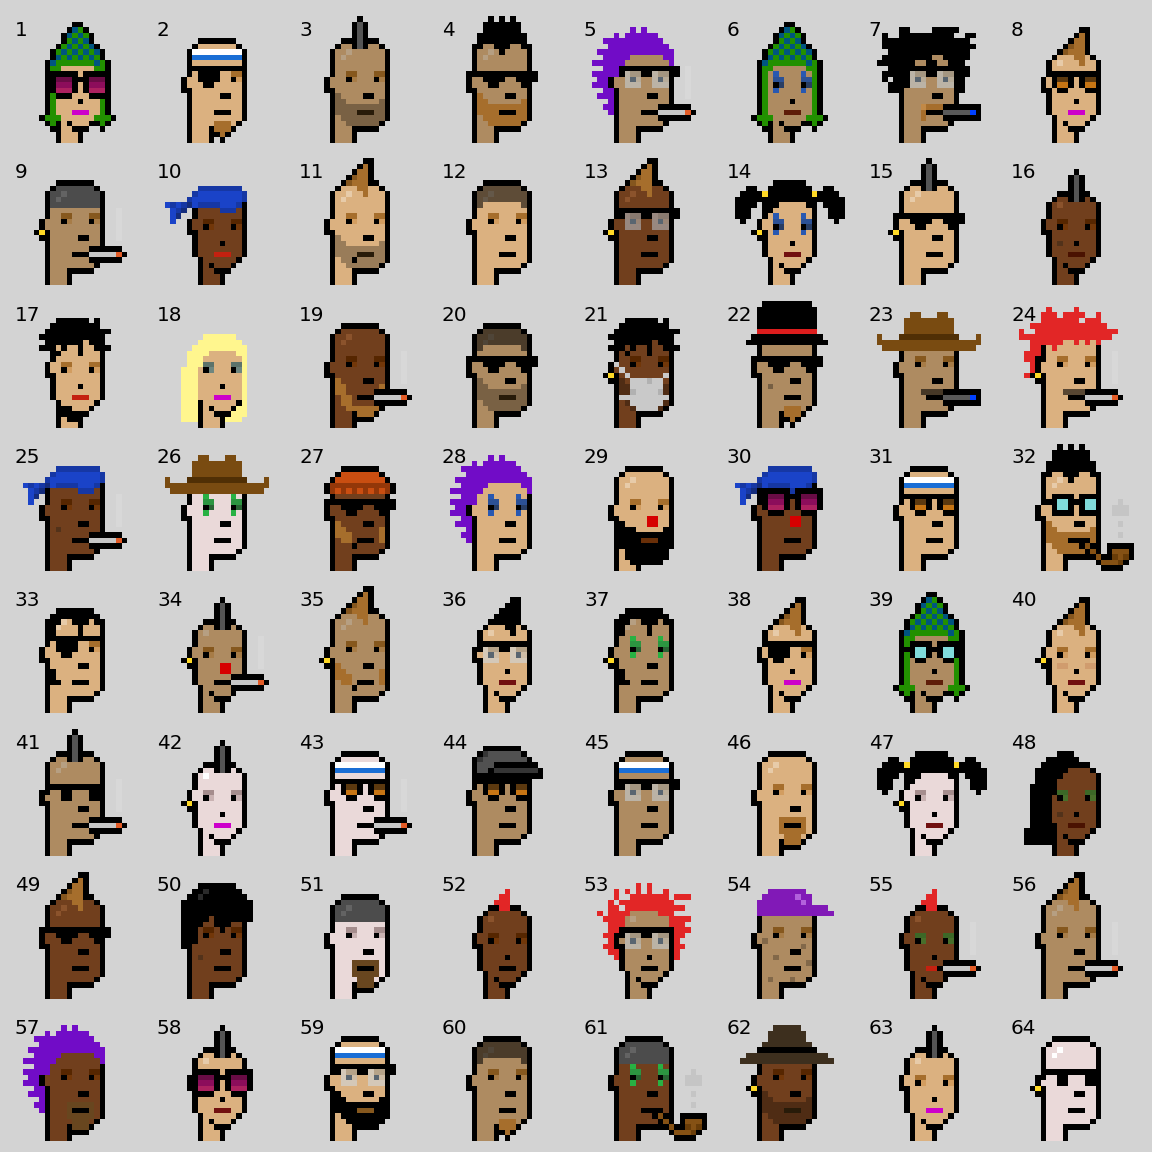
</div>

*Figure 2:* The 64 first images loaded with our seed.

We observe that the faces share a lot of features. For instance, 1, 6 and 39 have the same hair. The presence of such shared features is a what makes NMF a viable technique for reducing the information necessary to store the dataset. Instead of storing each feature in every image it occurs we can store all the features and the weights of these features for each image.


**Converting the dataset**

To apply NMF we want to turn our (24, 24, 4, N) array into a $m\times n$ matrix. For this project we only care about the color channels. We will therefore split the RGBA images into a RGB array of shape (24, 24, 3, N) and an opacity array (24, 24, 1, N) which we store for the plotting the reconstructed images after running out algorithm. Below we define a function to split the channels and reshape the RGB array into a $1728\times N$ matrix. We also define a function to reshape a $1728\times N$ back into an RGB array, and optionally remerge with the opacity.


In [11]:
def split_and_reshape(faces):
    """
    Splits color channels (RBG) from opacity/alpha channel (A) and reshapes the face array
    input:
        faces: 24x24x4xN array of images
    output: 
       faces_reshaped: 1728xN np.array with rgb values for the images without opacity
       faces_opacity: 24x24x500 array of opacity for images 
    """ 
    # Split channels  
    faces_opacity = faces[:,:,3,:]
    faces_rgb = faces[:,:,:3,:]
    shape = faces_rgb.shape
    
    # Clever reshape "trick". This is the matrix we will apply the NMF to
    N = faces.shape[-1]
    faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
    
    return faces_reshaped, faces_opacity

def merge_and_reshape(reshaped, opacity=np.array([])):
    """
    The inverse of split_and_reshape. 
    input:
        reshaped: 1728xN np.array with RGB values for the images without opacity
        opacity: 24x24x500 array of opacity for images. Default is empty array. In this case opacity is not added.
    output:
        faces: 24x24xYxN array. Y=3 (RGB) by default. If opacity is given Y=4 (RGBA)
    """
    # Find N, the number of images
    N = int(reshaped.size/1728)
    
    # Reshape faces and add opacity
    faces = np.reshape(reshaped, (24,24,3,N))
    if opacity.size > 0:
        opacity = np.reshape(opacity, (24,24,1,N))
        faces = np.concatenate((faces, opacity), axis=2)
    
    # Clip off values above 1.
    faces = np.where(faces<=1, faces, 1)
    
    return faces

## We reshape the faces with our function
faces500_reshaped, opacity500 = split_and_reshape(faces500)

**The *average* face and the rank of A**

Here, we'll look at the average of every face, and discuss it with regards to the rank of the matrix.

In [12]:
## The mean face: find and plot the average face
mean_face = np.mean(faces500, axis = -1)
# plotimgs(mean_face, 1, filename="2b_meanface.png", figsize = (3, 3))

## Set color to white if opacity is 0 
mean_face[:,:,0] = mean_face[:, :, 3] == 0
mean_face[:,:,1] = mean_face[:, :, 3] == 0
mean_face[:,:,2] = mean_face[:, :, 3] == 0 

num_opacity = np.sum(mean_face[:, :, 3]==0)
mean_face[:, :, 3] = 1

# plotimgs(mean_face, 1, filename="2b_0avg.png", figsize = (3, 3)) # hvit betyr her gjennomsnitt lik 0

## Merge the images
# plotimgs_merge(["2b_meanface", "2b_0avg"], f"2b_merged_img", ["Average face", "Non-zero pixels"])

print(f"The number of pixels with zero opacity = {num_opacity}\n")
print(f"np.linalg.matrix_rank gives rank = {np.linalg.matrix_rank(faces500_reshaped)}\n")
print(f"np.linalg.svd gives rank = {np.sum(np.abs(np.linalg.svd(faces500_reshaped)[1]) > 1.0e-13)}\n")

# plt.hist(np.log10(np.linalg.svd(faces500_reshaped)[1]))

The number of pixels with zero opacity = 166

np.linalg.matrix_rank gives rank = 377

np.linalg.svd gives rank = 377



<div>
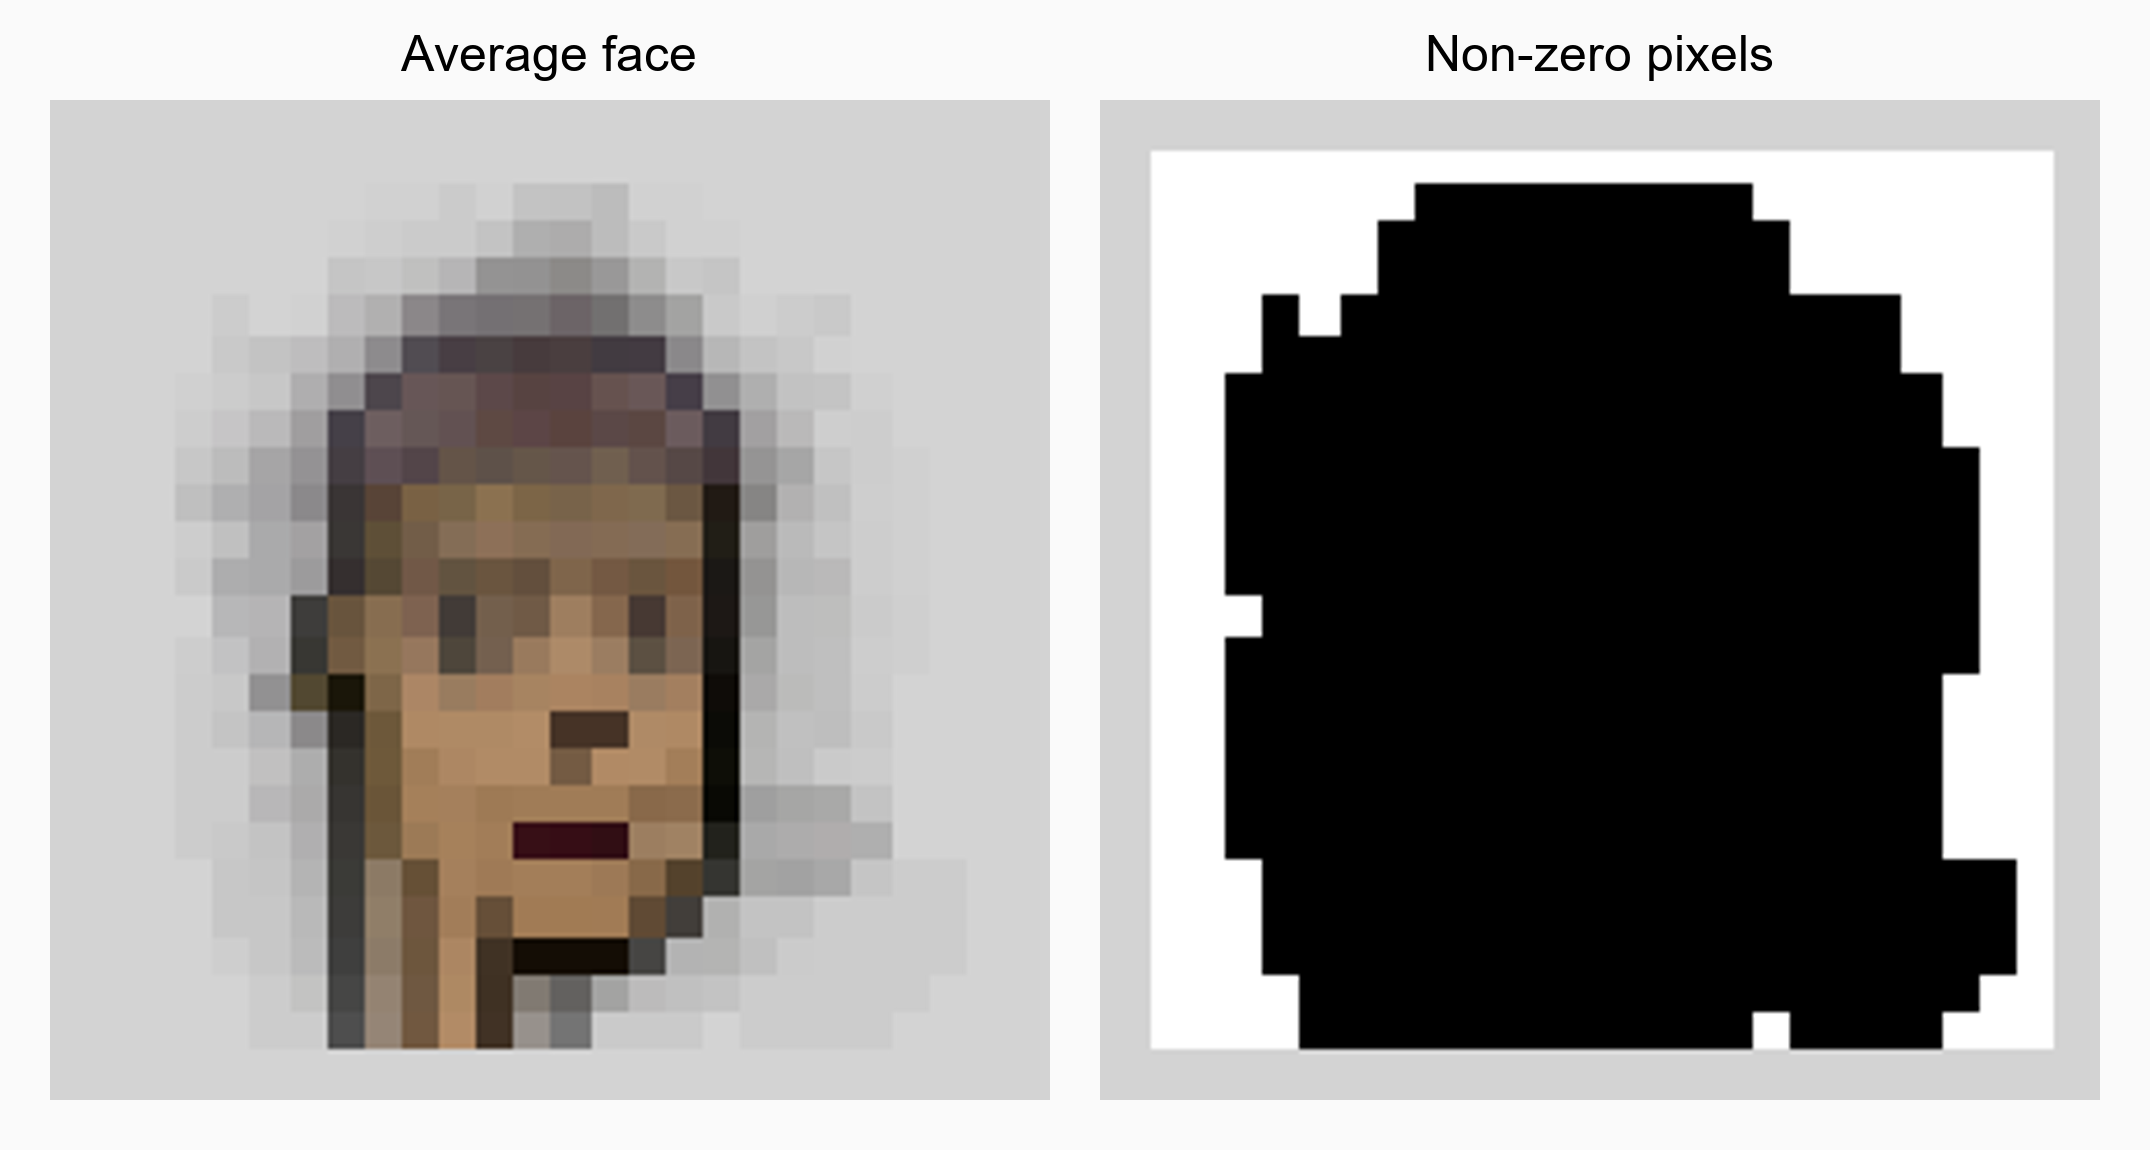
</div>

*Figure 3:* image of the average face, and image showing every nonzero pixel.

Averaging over every color channel for every pixel, we get the image on the left above. The distinct features of the above image yields much useful information about the dataset. Consider, for example, the very dark and clear and dark boundary of the face. This being an average image, we would expect most of the dataset having a face-boundary on or close to this one. The same can be said for the position of the eyes and the shape and placement of the mouth.  

Averaging over the opacity channel as well and creating an image with white pixels where the average opacity is zero, yields the image on the right. As it turns out, $166$ of the $24x24 = 576$ pixels on every image has an opacity of zero. This implies that at least $3x166=498$ rows (one for each color channel) are redundant or zero, as an opacity equal to zero practically makes the color transparent. Additionally, it puts an upper bound for the rank of the matrix, as these $498$ rows would be linearly dependent on the other rows, giving $1728-498=1330$ as an upper bound for the rank of the matrix. Being almost three times $N=500$, the upper bound is quite useless.



**The features of the dataset**

When reconstructing the images all that matters is the product $WH$. The scaling of $W$ and $H$ is determined by the seed initializing the NMF algorithm. We can let $W \rightarrow b\cdot W$ as long as $H \rightarrow \frac{1}{b}\cdot H$. We will therefore define a function to normalize the feature-matrix $W$ to get the same brightness when comparing its columns.


In [13]:
def normalize(W_matrix, H_matrix, brightness=0.025):
    """
    Normalizes W and H to have a standardized brightness when plotting the columns of W.
    input: 
        W_matrix: np.array of any shape
        H_matrix: np.array of any shape
        brighness: float, adjusts H and W such that avg(W) = brightness, without changing WH
    """
    W_normalized = W_matrix * brightness / np.average(W_matrix)
    H_normalized = H_matrix * (brightness / np.average(W_matrix))**(-1)
    return W_normalized, H_normalized


def reconstruction_images(d, maxiter=1000, N=500, basis_color=False, faces_to_plot=8, show=False):
    """
    Saves plot of the columns of W and faces_to_plot**2 reconstructions for a given number of features d.
    input:
        d: int, number of features
        maxiter: int, number of iterations
        N: int, number of images to perform NMF with
        basis_color: color of numbers on plot of columns of W, when False no numbers are added
        faces_to_plot: int, sqrt of the number of faces in the reconstruction plot
        show: bool, whether to show the plot below the code block
        brightness: Adjustment factor in case of dark W (Scaling W by a positive number b is okay as the weights in 
                    H can be scaled by 1/b. )
    output:
        none, saves the images as PNG
    
    """
    # Load and Reshape
    faces_reshaped_d, opacity_d = split_and_reshape(load_images(N))
    
    # Perform NMF algorithm
    W_d, H_d, err_d = NMF(faces_reshaped_d, d, maxiter = maxiter)
    W_d, H_d = normalize(W_d, H_d)
                
    # Reshape and plot basis
    if d > 1:
        W_columns_d = merge_and_reshape(W_d) # Any scaling of W is valid as we can scale H by 1/brightness 
        plotimgs(W_columns_d, int(d**(1/2)), filename=f"punks_basis_d{d}.png", number_color=basis_color, show=show)

    # Reshape and plot faces
    img_reconstructed_d = merge_and_reshape(np.dot(W_d, H_d), opacity_d)
    plotimgs(img_reconstructed_d, faces_to_plot, filename=f"{faces_to_plot**2}punks_d{d}.png", show=show)
    
## Reconstruction and basis for different d
n      = 4
d_vals = {16, 64, 144}
# for d in d_vals:
#     reconstruction_images(d, faces_to_plot=n, show=False)

# plotimgs_merge([f"punks_basis_d{d}" for d in d_vals], "basises",               img_txt=[f"d = {d}" for d in d_vals])
# plotimgs_merge([f"{n**2}punks_d{d}" for d in d_vals], f"multiple_{n**2}punks", img_txt=[f"d = {d}" for d in d_vals])

# # Basis and reconstruction
# reconstruction_images(8**2, basis_color="white")
# plotimgs_merge([f"{8**2}punks_d{8**2}", "2a_punks"], "2d_reconstruction_comparison", ["Reconstruction", "Original"])

<a class="anchor" id="W_columns"></a>

<div>
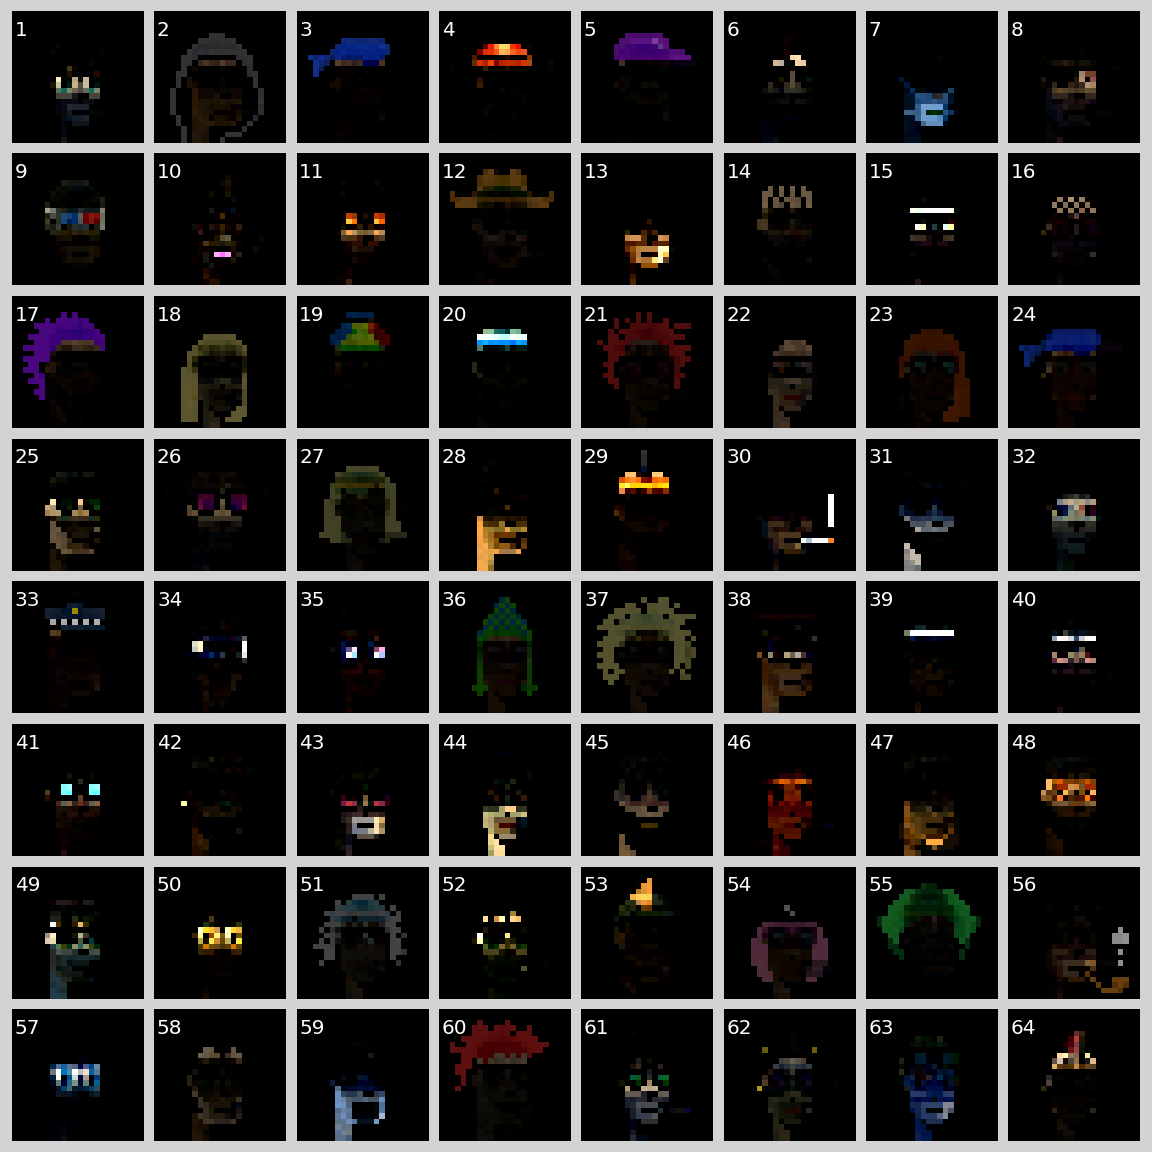
</div>


Figure 4: Columns of $W$ interpreted as RGB images, using $d=64$.

From the plot it seems that the columns of $W$ represent distinct features of the images, like skin color for parts of the face, a certain hairstyle or an accessory like glasses. We can recognize a lot of these features from the original images, like the blue bandana in the third column. Therefore, we would argue that the NMF captures the important features of the dataset.

When we vary $d$, we can see that smaller values results in the columns being less distinct. By this we mean that they display larger areas of the face, and some contain multiple features like the lower left column displaying both glasses and a larger area of the face. This will lead to an inferior reconstruction of the original images as some of the nuances and finer details will be lost. For bigger $d$ the columns become more distinct, representing individual features. We can even notice that some features are displayed in multiple columns, like the blue bandana appearing twice with $d=64$ and even more times with $d=144$. Larger values for $d$ mean that more of the details in the images will be maintained and should therefore lead to a better reconstruction.



We also tried different values for $d$:

<div>
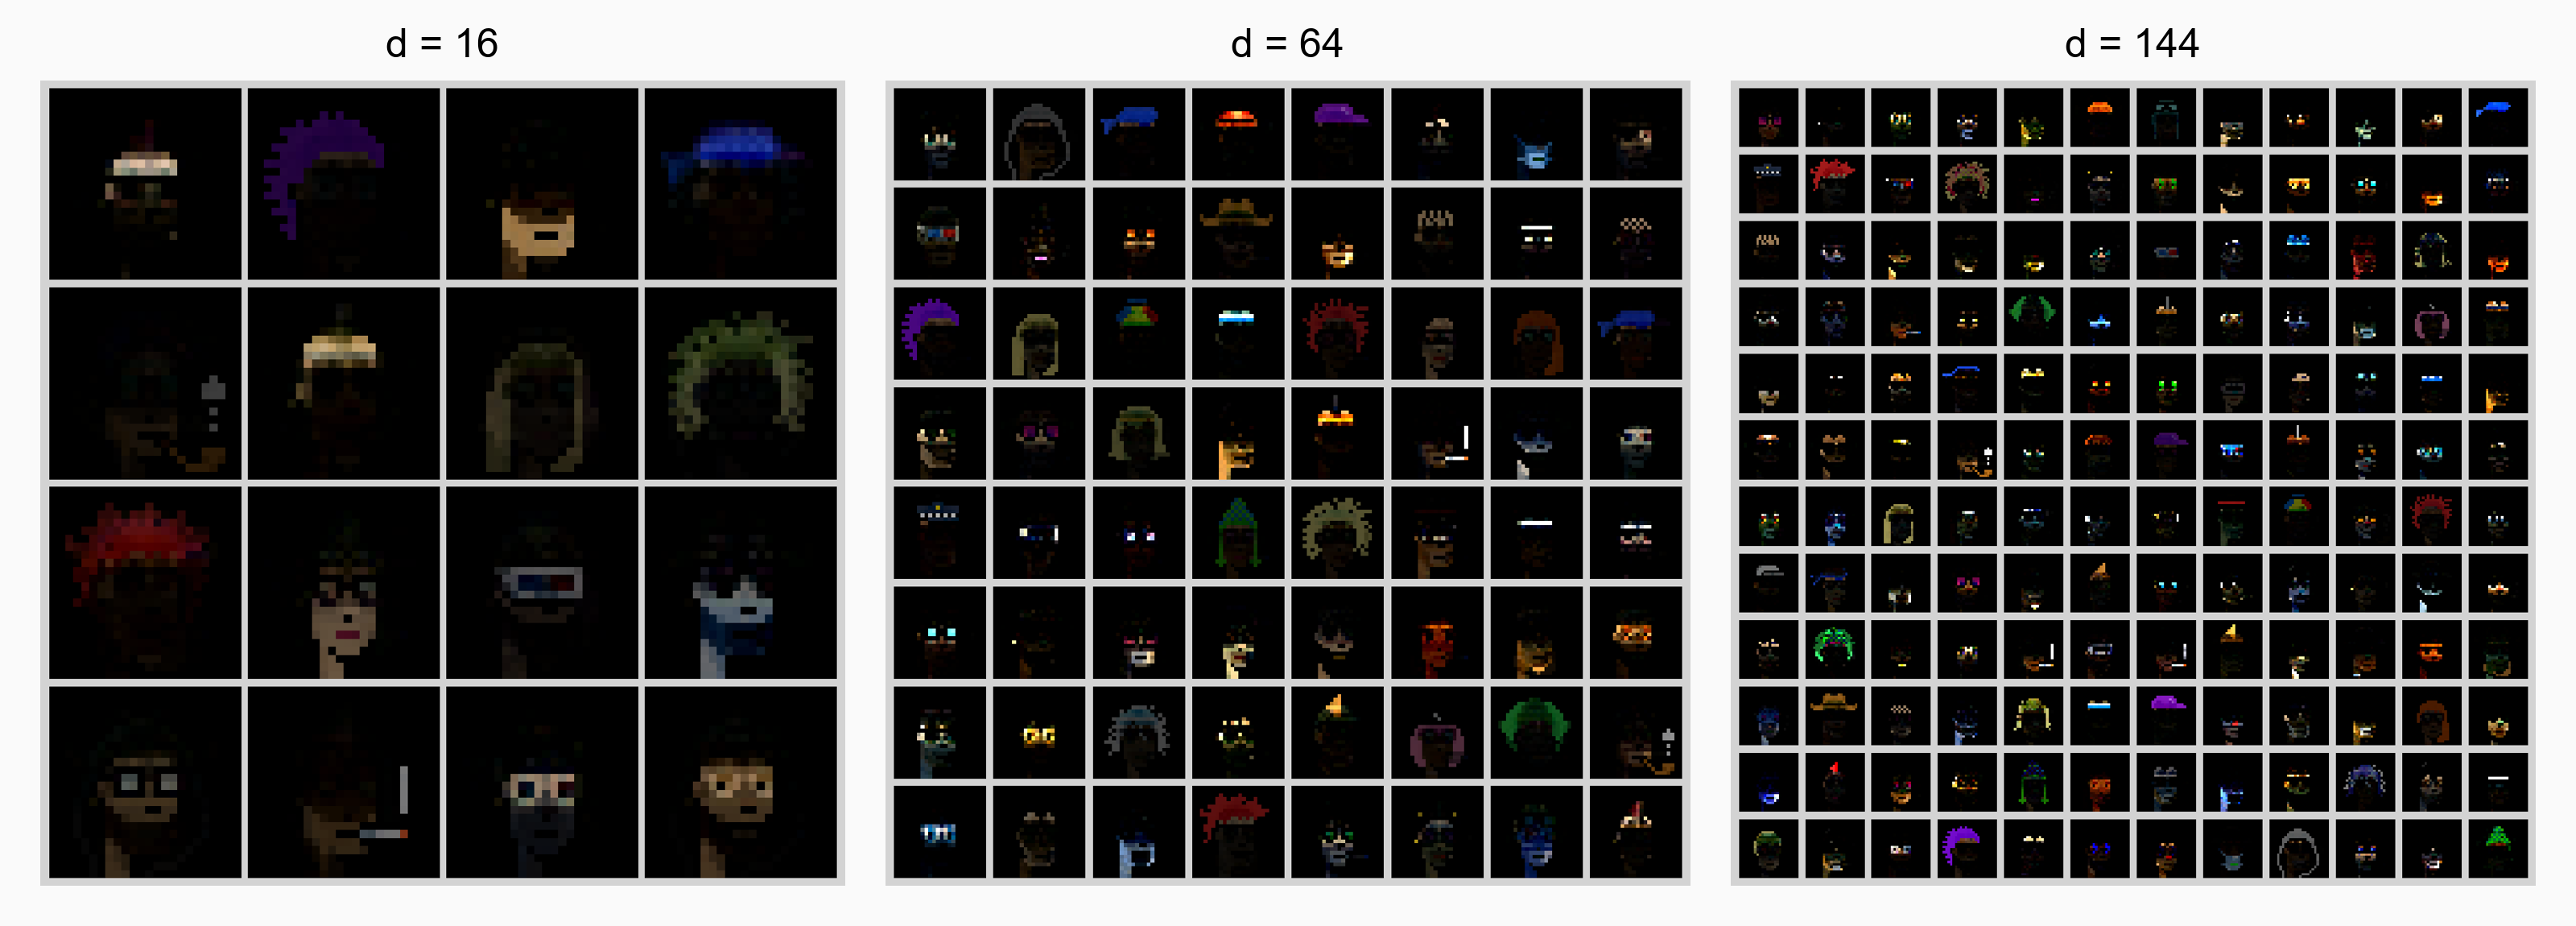
</div>

*Figure 5:* Columns of $W$ interpreted as RGB images, with different values of $d$.



**Reconstructing the dataset**

<a class="anchor" id="2d_reconstruction_comparison"></a>

<div>
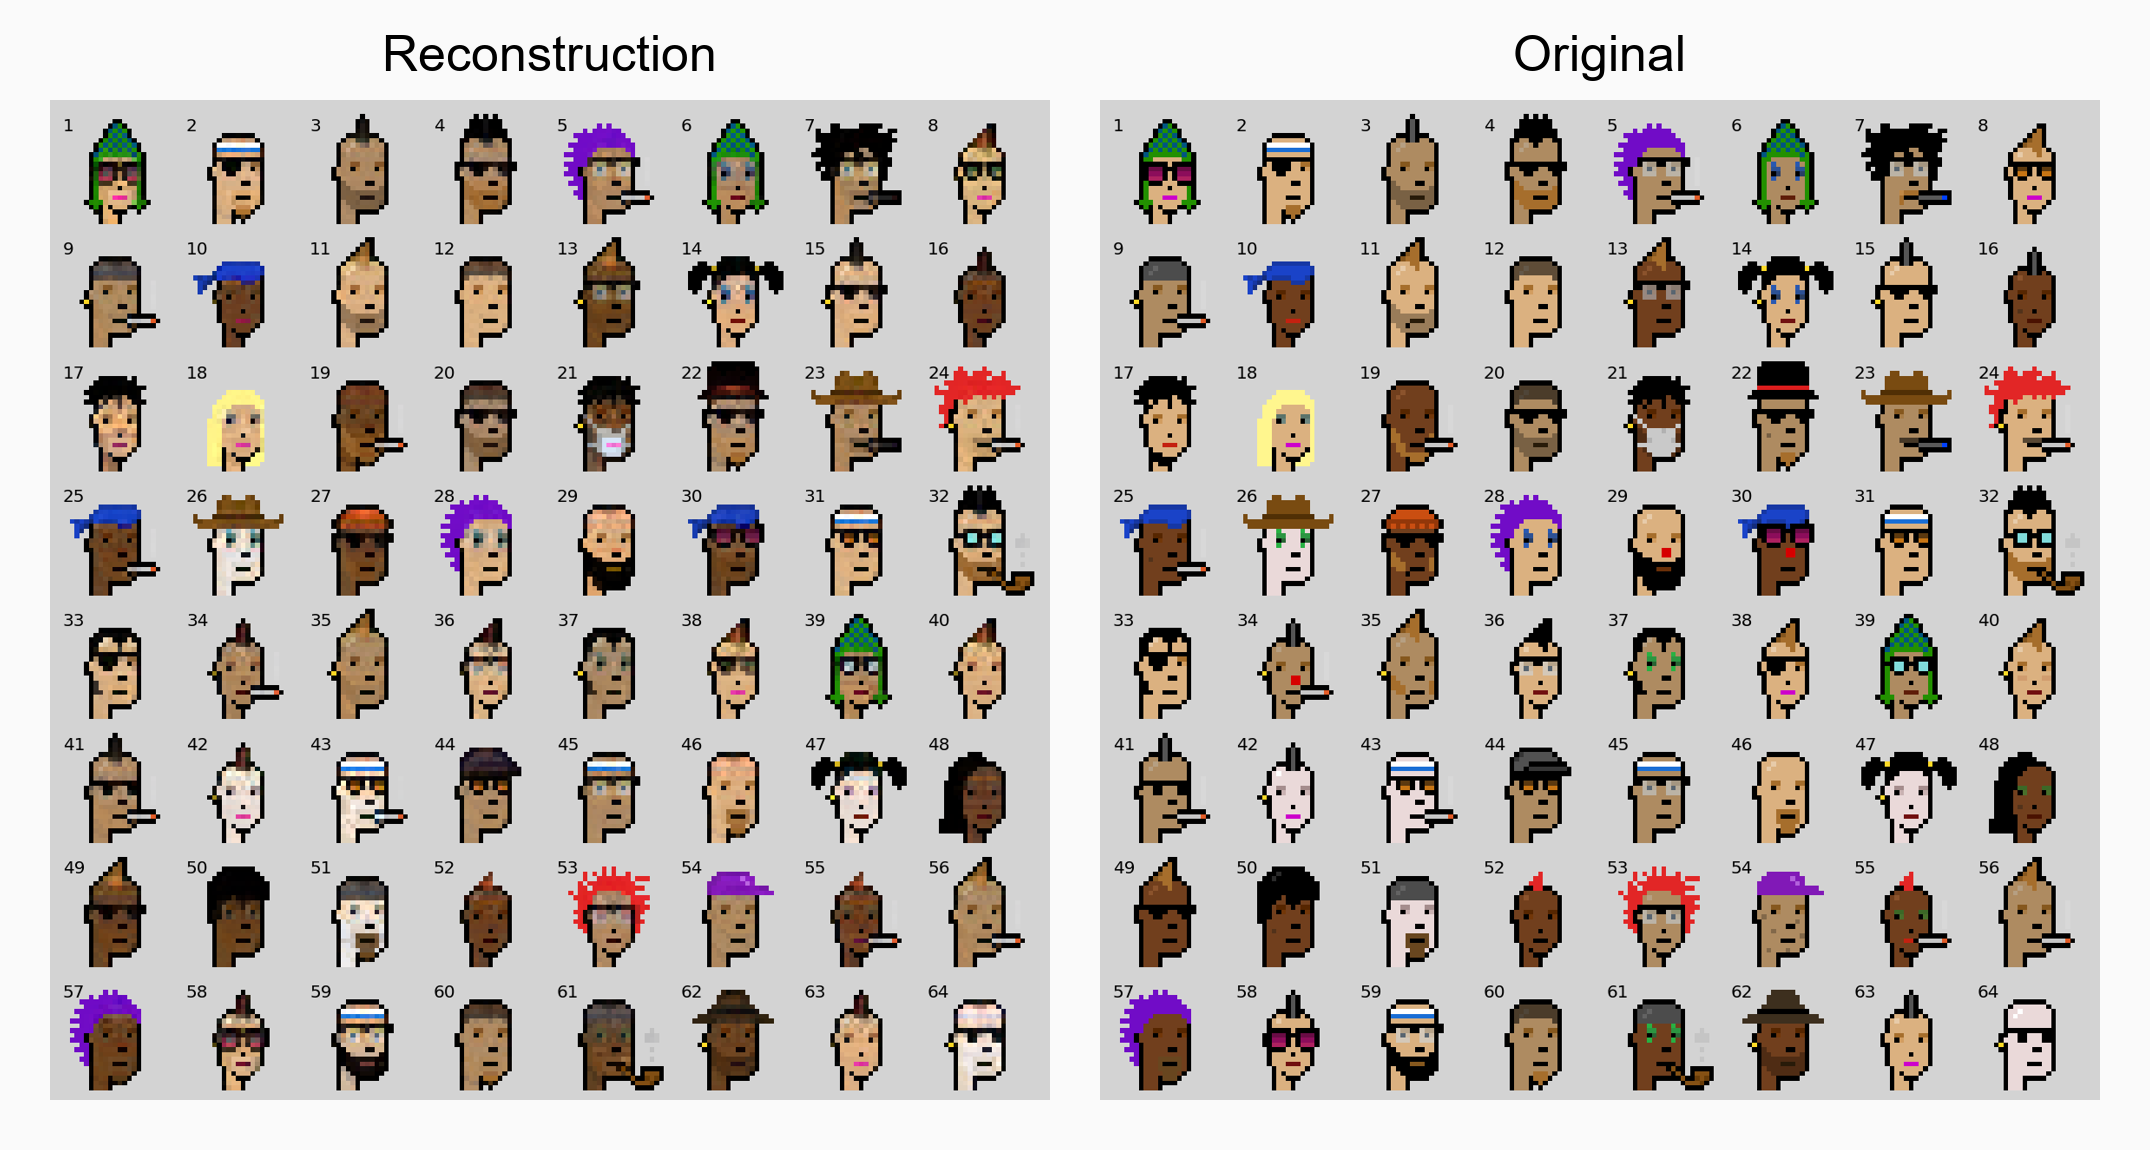
</div>


Figure 6: Reconstructed and original images, using $d = 64$. Later we will compare these reconstructions to [noisy reconstructions](#3d_reconstruction_comparison).


With $d=64$ we would definitely say that the reconstructions are overall satisfactory. At first glance the reconstructions might look almost identical to the original images, but by taking a closer look one can notice some miscoloring of the skin. For the most part the distinct features of images are effectively reconstructed, though there are some exceptions. For example, the face mask in image 21 which looks quite different from the original, or the red nose in image 29 which has completely disappeared.




We will also look at the reconstructions with different values of $d$: 

<div>
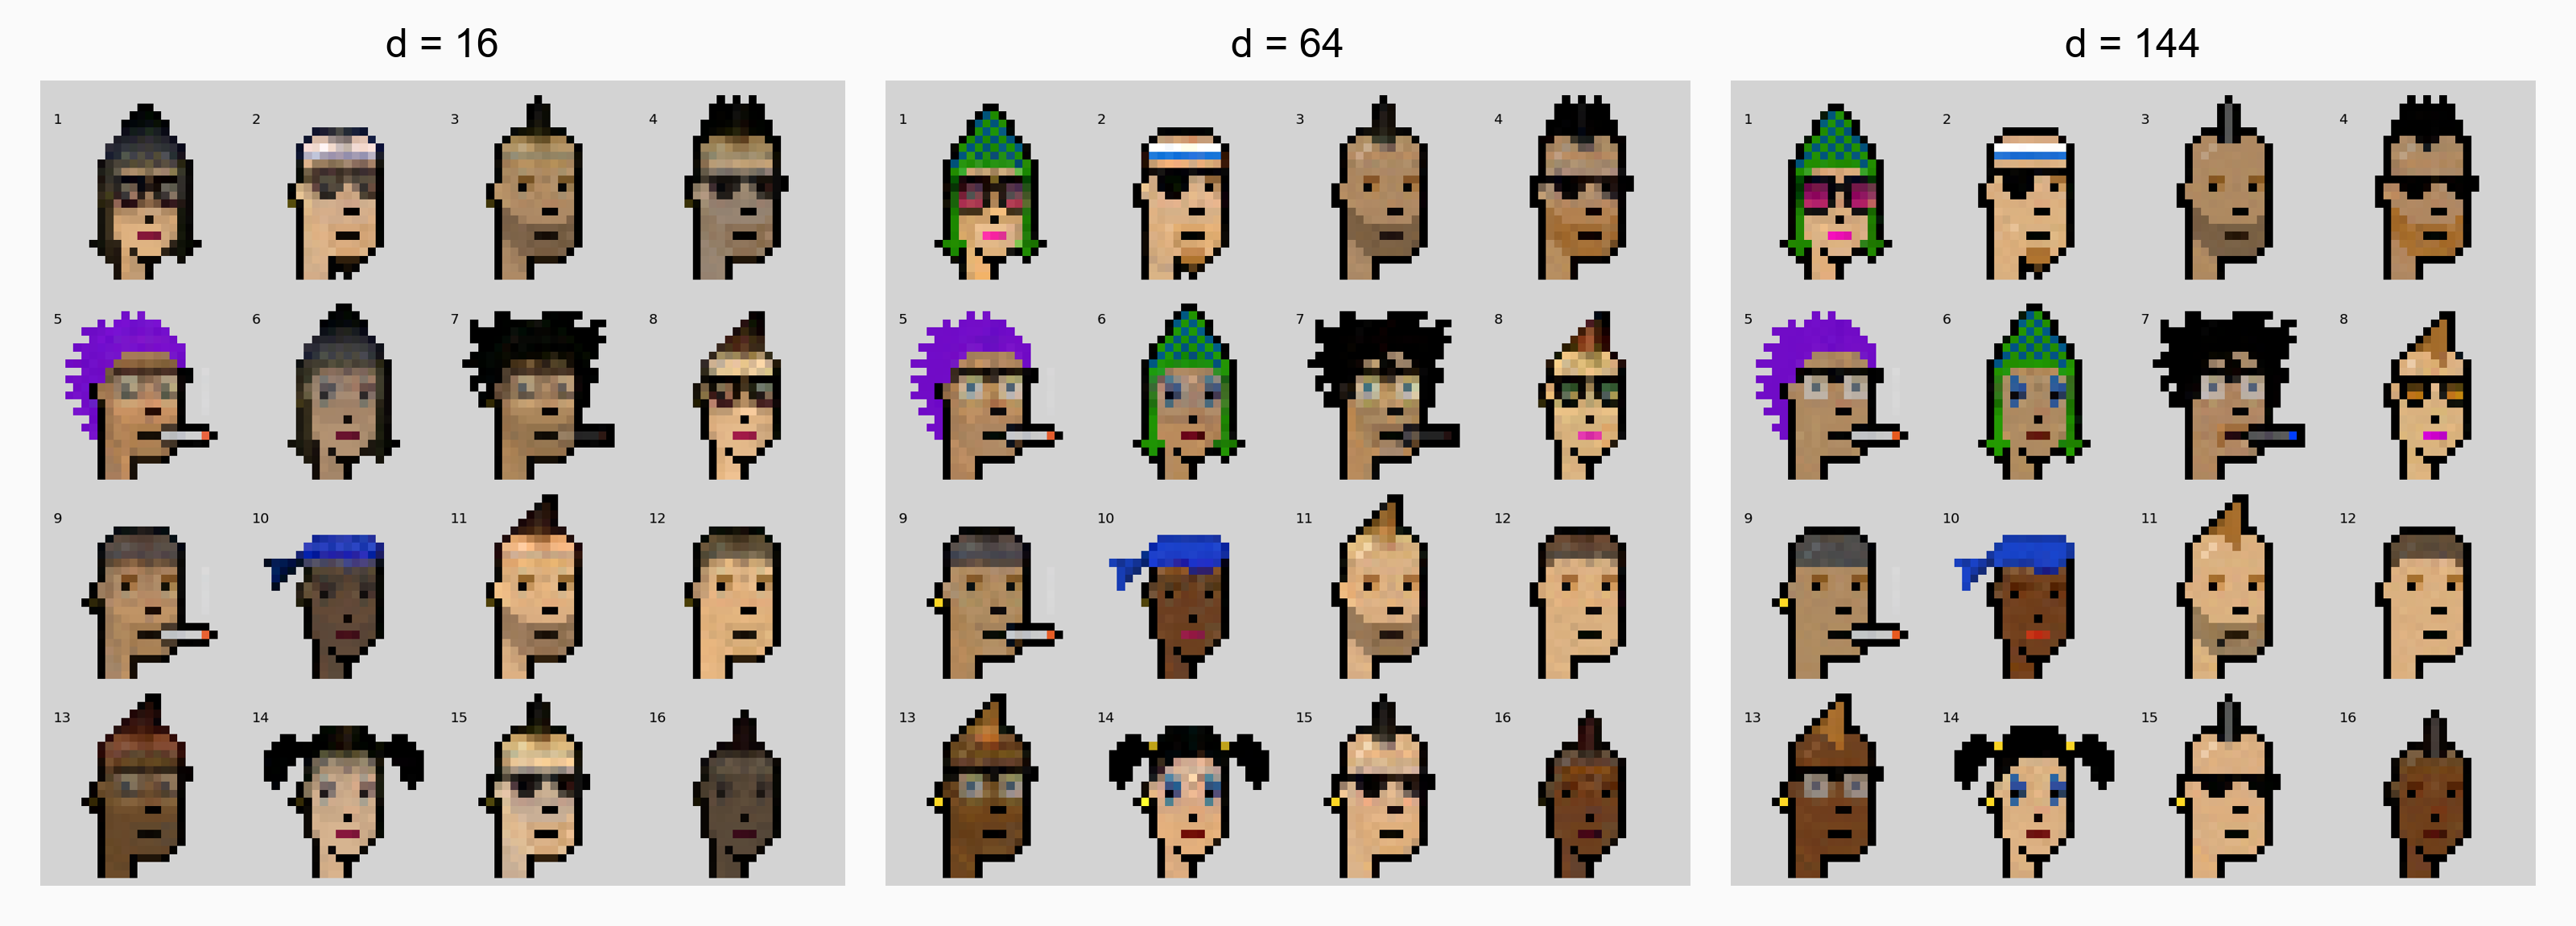
</div>

Figure 7: Reconstructed images, for different values of $d$.

From figure 7 we notice a significant difference between $d=16$ and $d=64$. The miscoloring of the skin is much more prevalent and the images generally look greyer. In addition, some features are lost like the green hair in image 1 turning black and glasses in image 7 disappearing. The difference between $d=64$ and $d=144$ does not seem to be as big, but there is clearly less miscoloring with the latter. Furthermore, the tip of the black cigarette keeps the blue color blue which was lost with $d=64$.


**Convergence, again**

When considering the error of the reconstructions we want a number that doesn't depend on the number of images $N$. 
We want a measure of the error per image. The division by $\sqrt{N}$ solves this:

$$
\begin{align}
    ||A_{M\times N}||_F = \sqrt{\sum_j^N{\sum_i^M{a_{i,j}^2}}} 
                        = \sqrt{\sum_j^N{{||\vec a_{j}||_F^2}}} 
                        = \sqrt{N\cdot \overline {{||\vec a||_F^2}}} 
                        = \sqrt{N}\sqrt{\cdot \overline {{||\vec a||_F^2}}}
                        = \sqrt{N}\cdot ||\vec a||_{F, \textrm{RMS}}.
\end{align}
$$

We see that the root mean square of the Frobenius norm of the column errors is given by:

$$
    ||\vec a - W \vec h||_{F, \textrm{RMS}} = \frac{1}{\sqrt{N}} \cdot ||A-WH||_F
$$

Where $\vec a$ and $\vec h$ are corresponding columns in $A$ and weights in $H$.



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

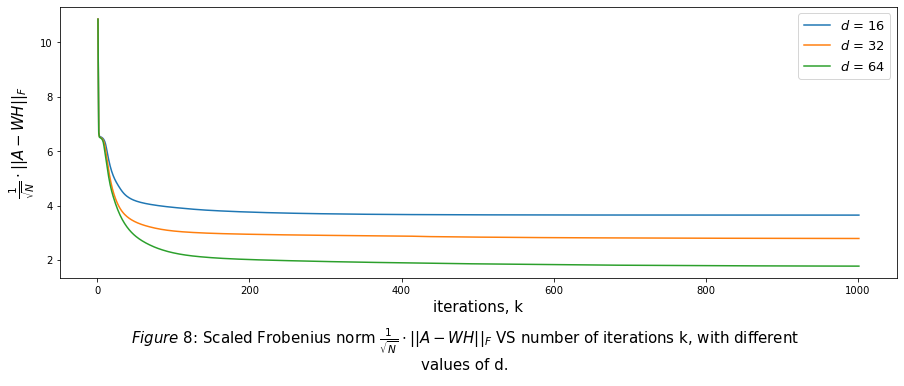

In [14]:
def error_sim(faces_reshaped, maxiter=1000, d_vals=[16, 32, 64]):
    """
    Performs maxiter iterations of NMF for d in d_vals on faces_reshaped and plots the errors.
    input: 
        faces_reshaped: 1724*N anumpy array
        maxiter: int, number of NMF iterations
        d_vals: list of feature numbers d
    output:
        none, plots the results
    """
    N = faces_reshaped.shape[1] # Number of images, used to standardise error
    # Initialise error array and do NMF for d values
    image_error_arrays = []
    for d in tqdm(d_vals, leave = False):
        image_error_arrays.append(NMF(faces_reshaped, d, maxiter=maxiter)[2]/np.sqrt(N)) # øke maxiter
    
    # Plot the results
    txt = r"$Figure$ 8: Scaled Frobenius norm $\frac{1}{\sqrt{N}}\cdot||A-WH||_F$ VS number of iterations k, with different values of d."
    plot_function([[np.arange(1, maxiter+2) for d in d_vals]], [image_error_arrays], [["tab:blue", "tab:orange", "tab:green"]], 
        fig_size=(15, 5), xlabels=["iterations, k"], ylabels=[r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$"],#r'$||\vec{a}-W\vec{h}||_{F, \mathrm{RMS}}$']
        fig_text=txt, fig_text_y = -0.12, labels=[[f"$d$ = {d}" for d in d_vals]])

error_sim(faces500_reshaped, maxiter = 1000)

Figure 8 clearly shows that the scaled Frobenius norm decreases with increasing $k$. Expectedly we notice that the reduction of the norm is similar to what we saw in [figure 1](#figure_1), with a steep slope for small $k$ while flattening out as $k$ grows larger. The figure also shows that larger values of $d$ results in a smaller error, which is reasonable considering larger $d$ means the NMF contains more data about the original matrix. In addition, larger $d$ seems to require more iterations before converging, which is likely a result of the NMF containing more values to be tweaked. Still the algorithm looks to have converged for all three values of $d$.


**$d$-dependance of the reconstruction error**


We will now do NMF calculation for a wide range of $d$ to investigate how the reconstruction error, $\lvert\lvert A - WH \rvert\rvert_F$. We expect that the error is reduced as we capture more features in matrix $W$. 

For an $m\times n$-matrix we want to choose a value for $d$ such that the total information is reduced:

$$
\begin{align}
mn &< md+dn \\
d &< \frac{mn}{m+n}. 
\end{align}
$$



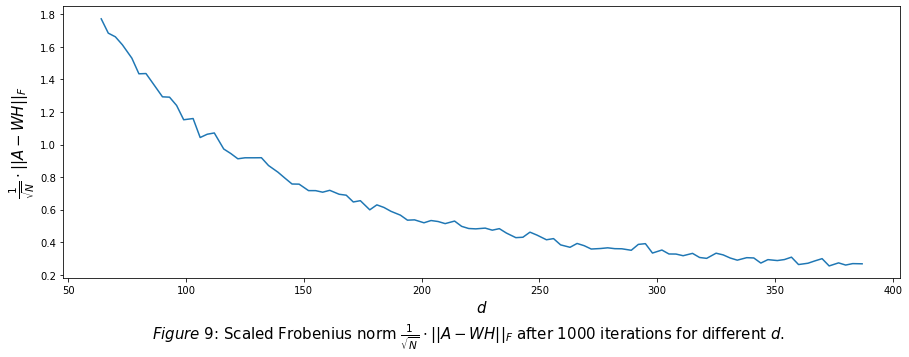

In [15]:
def final_error_sim(d_vals, N=500, maxiter=1000, data_title=False):
    """
    Computes the final error for each d in d_vals after 1000 NMF iterations. Option to save in file with data_title
    input:
        d_vals: list of d values
        N: int, number of images to load
        maxiter: int, number of NMF iterations
        data_title: title for data file. if False no data is saved
    output:
        final_error_es: the final error for each d in d_vals
    """
    # Load, reshape and add noise to images
    faces_es          = load_images(N)
    faces_reshaped_es = split_and_reshape(faces_es)[0]
    faces_r_noisy_es  = split_and_reshape(faces_es)[0] # We need faces_reshaped_es for error comparison
        
    # Initialise arrays for final errors
    final_error_es = np.zeros(len(d_vals))

    # We do the simulation for all the d values
    for i in tqdm(range(len(d_vals)), leave = False):
        W_es, H_es, err_es = NMF(faces_r_noisy_es, d_vals[i], maxiter = maxiter)
        final_error_es[i]  = err_es[-1]
    
    # SAVE DATA
    if data_title:
        np.savez(data_title, d_vals=d_vals, final_error = final_error_es)
        
    return final_error_es
    
# To run this cell, uncomment the line below. Warning: run at own risk. Reduce some parameters to reduce runtime.
N = 500
number_of_d = 1000
d_vals = np.linspace(64, np.floor(1728*N/(1728+N)), number_of_d, dtype = 'int')
# final_error = final_error_sim(d_vals, maxiter = 1000, data_title = "###2f.npz")

# Load data from commented line and make plot
data = np.load("2f.npz")
d_vals = data['d_vals']
final_error = data['final_error']

txt = r"$Figure$ 9: Scaled Frobenius norm $\frac{1}{\sqrt{N}}\cdot||A-WH||_F$ after 1000 iterations for different $d$."
plot_function([[d_vals]], [[final_error/np.sqrt(500)]], [["tab:blue"]], 
        fig_size=(15, 5), xlabels=[r"$d$"], ylabels=[r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$"], fig_text=txt)

<a class="anchor" id="figure_9"></a>

As the plot above shows, the Frobenius difference between $A$ and $WH$ is a decreasing function of $d$. 

**Analysis with Singular Value Decomposition**


To get zero error, $W$ and $H$ must be tuned so that $WH$ is exactly equal to $A$. For $d < \frac{mn}{m+n}$, the total number of elements in $W$ and $H$ combined would be less than the total number of elements in $A$, meaning $A$ could be reproduced exactly using fewer elements than it originally had. 

Using the theory of Singular Value Decomposition, we know that $A$ can be decomposed into a product of three matrices $A = U\Sigma V^T$, or equivalently the two matrices $U$ and $\Sigma V^T$. If some of the singular values are zero, the rightmost columns of $U^T$ would be redundant, as they're multiplied by zero in the matrix product $\Sigma V^T$. 

It can be shown that the best approximation to a matrix $A$ with lower rank than $A$ itself is the truncated SVD. In general, an SVD cannot be characterized as an NMF because of the "Non-negativity" criteria (The singular values and the elements in $U$ and $V$ may not be positive). However, if every element produced by the SVD happened to be positive, it would correspond to a non-negative matrix factorization (multiply either $U$ or $V$ by $\Sigma$). For a given matrix of rank $n$ then, to be able to approximate the matrix as well as the truncated SVD of rank $d^\prime \leq n$, the corresponding value of $d$ would need to be at least $d^\prime$. Therefore, the smallest $d$ that could (theoretically) yield a perfect NMF of a matrix $A$ is the number of nonzero elements in the SVD of $A$. 


**Proof of norm-reduction**

If the algorithm always produced the global minimum, the following theorem shows that the Frobenious norm must decrease when increasing $d$.

**Theorem:**
Given $A \in \mathbb{R}^{m\times n}$. Let $W \in \mathbb{R}^{m\times d}$ and $H \in \mathbb{R}^{d\times n}$ be a solution to the optimization problem

$$
    \min_{W, H} ||A-WH||_F, \, \textrm{s.t} \, W,H \, \textrm{non-negative}.
$$

Furthermore, let $W' \in \mathbb{R}^{m\times d+1}$ and $H' \in \mathbb{R}^{d+1\times n}$  be a solution to the optimization problem

$$
    \min_{W', H'} ||A-W'H'||_F, \, \textrm{s.t} \, W',H' \, \textrm{non-negative},
$$

then 

$$
    \lVert A - W'H'\rVert _F \leq \lVert A - WH\rVert _F,
$$

with equality only when $WH=A$.

**Proof:**
We first prove that not every element in $WH$ can be larger than the corresponding element in $A$. Suppose $Z = WH$ is the solution to the optimization problem 

$$
    \min_{W, H} ||A-WH||_F, \, \textrm{s.t} \, W,H \, \textrm{non-negative}.
$$

Assume $a_{ij} \leq z_{ij} \, \forall i, j$, and let 

$$
\varepsilon \equiv \frac{1}{mn}\sum_{i, j}(z_{i, j} - a_{i, j}) \geq 0.
$$

The inequality follows from our assumption. Consider now the matrix $Z'$ given by $z_{ij}' = z_{ij} - \varepsilon$. This has the Frobenius norm:

$$
\begin{align}
    \lVert A - Z'\rVert _F^2 &= \sum_{i, j} (a_{ij}-z'_{ij})^2 
                             = \sum_{i, j} (a_{ij}-z_{ij}+\varepsilon)^2 \\
                             &= \sum_{i, j} (a_{ij}^2 - z_{ij}^2 + \varepsilon^2 - 2a_{ij}z_{ij} -2\varepsilon z_{ij} + 2a_{ij}\varepsilon) \\
                             &= \sum_{i, j}(a_{ij}-z_{ij})^2 + \sum_{ij} \varepsilon^2 - 2\varepsilon\sum_{i, j} (z_{ij}-a_{ij}) \\
                             &= \lVert A - Z\rVert _F^2  + mn\varepsilon^2 - 2\varepsilon mn\varepsilon \\
                             &= \lVert A - Z\rVert _F^2  - mn\varepsilon^2 
                             \leq \lVert A - Z\rVert _F^2
\end{align}
$$

This tells us that any reconstruction $W$ of $A$ must either be perfect with $\varepsilon = 0$ or there exists at least one pair of numbers $i, j$ such that $z_{ij} < a_{ij}$. 

Create the matrices $W'$ and $H'$ by adding a column full of zeros to $W$ and a row full of zeros to $H$. The key insight is that this gives $WH = W'H'$

$$
    (W'H')_{ij} = \sum_{k=1}^d w_{ik}h_{kj} = \sum_{k=1}^{d-1} w_{ik}h_{kj} + w_{id}h_{dj} = (WH)_{ij} + W_{id}' H_{dj}'.
$$

Where $W_{id}'=H_{dj}' = 0$. We've shown that $A_{ij}-(WH)_{ij} > 0$ for at least one pair of $i, j$ (as long as $WH \neq A$). We can therefore choose

$W_{id}'=H_{dj}'=\sqrt{A_{ij}-(WH)_{ij}}$, yielding  

$$
(W'H')_{ij}=(WH)_{ij} + W_{id}' H_{dj}=(WH)_{ij} + A_{ij}-(WH)_{ij} = A_{ij}.
$$

The Frobenius error in the new matrix would therefore decrease. This means that increasing d will always make it possible to decrease the total Frobenius difference between $A$ and $WH$ as long as $WH \neq A$. By the discussion concerning the histogram in [figure 10](#figure_10), the algorithm reaches roughly the same minimum for many simulations, indicating that the algorithm reaches a value almost equal to the global minimum.


**Global and local minima**

Before moving on to denoising we do a final simulation to see if we seem to hit the same minimum with different seeds. 


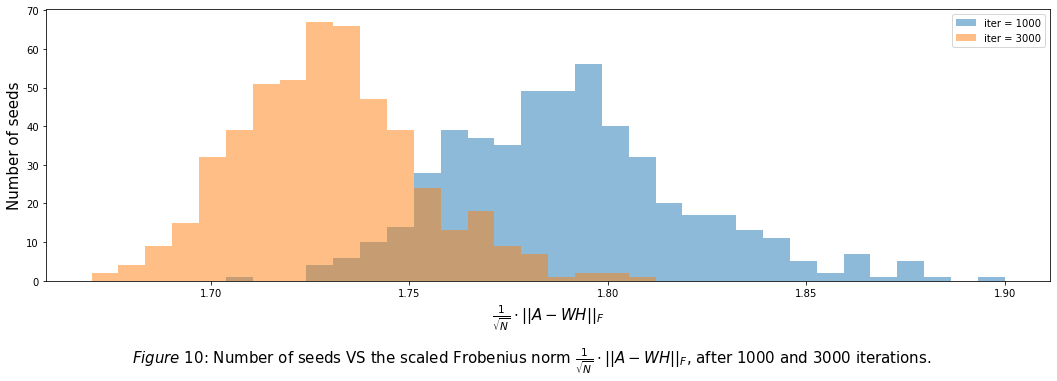

In [16]:
def seed_test(number_of_seeds, maxiter=1000, d=64, N=500, seed=4269, data_title="seed_test"):
    """
    Computes and saves the reconstruction errors for different seeds
    input:
        number_of_seeds: int, number of seeds to test
        maxiter: int, number of NMF iterations
        d: int, number of features
        N: int, number of images
        seed: int, seed to generate seeds with
        data_title: title for npz file with data
    output:
        none, seeds and reconstruction_errors are saved to data_title.npz
    """
    # Load and split faces
    faces_reshaped_s = split_and_reshape(load_images(N))[0] # index 1 is the opacity channel
    
    # Prepare array of seeds
    np.random.seed(seed)
    seeds = np.random.choice(range(number_of_seeds*10), number_of_seeds, replace=False)
    
    # Initialise list to store the different reconstructions errors
    reconstruction_errors = []
    
    # Do NMF simulation and append reconstruction for each seed
    for i in tqdm(range(number_of_seeds)):
        W_s, H_s, err_s = NMF(faces_reshaped_s, d, maxiter=maxiter, seed=seeds[i])
        reconstruction_errors.append(err_s[-1])
    
    # Save the data
    
    np.savez(data_title, seeds=seeds, reconstruction_errors=reconstruction_errors)

n        = 500
iter_arr = [1000, 3000]
## Do seed tests
# for i in iter_arr:
#     ###seed_test(n, maxiter = i, data_title = f"###{n}seeds_{i}iter.npz")

## Plot histogram
fig, ax = plt.subplots(figsize = (18, 5))
bins = np.linspace(1.67, 1.90, 35)
for i in iter_arr:
    reconstruction_errors = np.load(f"{n}seeds_{i}iter.npz")["reconstruction_errors"]
#     print(min(reconstruction_errors)/np.sqrt(500), max(reconstruction_errors)/np.sqrt(500))
    ax.hist(reconstruction_errors/np.sqrt(500), bins, alpha = 0.5, label = f"iter = {i}")
ax.legend(loc = "upper right")
ax.set_xlabel(r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$", fontsize = 15)
ax.set_ylabel("Number of seeds", fontsize = 15)
plt.figtext(0.5, -0.1, r"$Figure$ 10: Number of seeds VS the scaled Frobenius norm $\frac{1}{\sqrt{N}}\cdot||A-WH||_F$, after 1000 and 3000 iterations.", wrap=True, horizontalalignment='center', fontsize = 15)

plt.show()

<a class="anchor" id="figure_10"></a>

The histogram above shows that the interval of errors becomes narrower by increasing the number of iterations. This indicates that the seeds converge towards the same minimum, indicating that we do indeed reach the global minimum. Another key insight is that a few seeds converge a lot slower or faster than the rest. We have used the same seed throughout this project, but a seed that works well for one feature number $d$ might not be optimal for another. This could explain the lack of smoothness in the errors in [figure 9](#figure_9). There we saw that the error sometimes *increased* when increasing $d$.


## Denoising <a class="anchor" id="denoising"></a>

In this last section, we will add gaussian distributed noise to the CryptoPunk images and analyze the NFM-algorithms capability to remove it.

We model the noise as:

$$A_{\textrm{noisy}} = A + \sigma E,$$

where $\sigma > 0 $ is our *noise level*, and $E$ sampled from $\mathcal{N}(0, 1)$. Below is the handed-out function to add noise to the images.


In [17]:
def add_noise(imgs_reshaped, sigma=0.1, seed=4269):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = imgs_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    np.random.seed(seed)
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

In [18]:
## Add noise to images
faces500_reshaped_noisy = add_noise(faces500_reshaped, sigma = 0.1)

## Calculate the error of the noisy images
noise500_error = np.linalg.norm(faces500_reshaped_noisy - faces500_reshaped, 'fro') 
print(f"Total frobenius norm of noisy matrix: {noise500_error}")
print(f"Scaled frobenius norm of noisy matrix: {noise500_error/np.sqrt(500)}")

## For plotting noisy images we add the opacity
faces500_noisy = merge_and_reshape(faces500_reshaped_noisy, opacity500)
# plotimgs(faces500_noisy, filename = "3a_noisy_punks.png", show=False)

Total frobenius norm of noisy matrix: 42.1342007245691
Scaled frobenius norm of noisy matrix: 1.8842987399551479


<div>
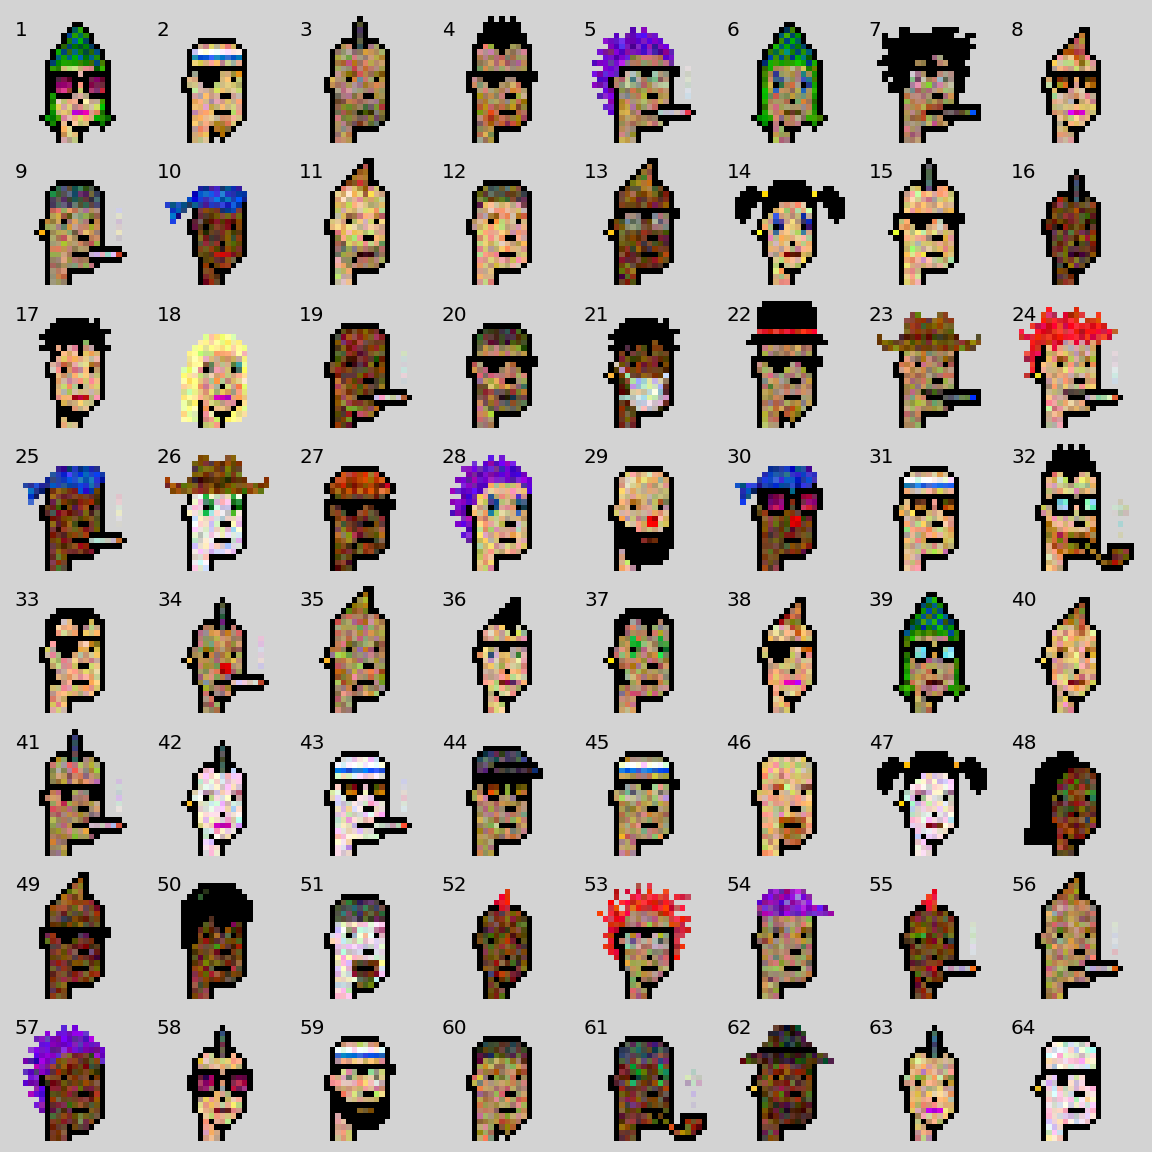
</div>


*Figure 11:* The 64 first images, with added noise. 


We will now do the same analysis of the feature-plot as previously.

In [19]:
d = 64
W_noisy, H_noisy, err_noisy = NMF(faces500_reshaped_noisy, d, maxiter = 1000) # øke maxiter!!
print("Initital error:  ", noise500_error/np.sqrt(500))
print("After denoising: ", np.linalg.norm(np.dot(W_noisy,H_noisy) - faces500_reshaped, 'fro')/np.sqrt(500))

W_columns_noisy = merge_and_reshape(normalize(W_noisy, H_noisy)[0])
# plotimgs(W_columns_noisy, 8, filename="3b_punks_basis_noisy.png", figsize = (12, 12), number_color = "white")
# plotimgs_merge(["3b_punks_basis_noisy", f"punks_basis_d{64}"], "3b_basis_comparison", [f"\u03C3 = 0.1", "\u03C3 = 0"]) 

images_noisy_reborn = merge_and_reshape(np.dot(W_noisy, H_noisy), opacity500)
# plotimgs(images_noisy_reborn, 8, filename="3b_noisy_reconstructions.png", figsize = (12, 12))
# plotimgs_merge([f"3b_noisy_reconstructions", "3a_noisy_punks"], "3b_recoonstruction_comparison", 
#                ["Reconstruction", "Noisy faces"]) 

  0%|          | 0/1000 [00:00<?, ?it/s]

Initital error:   1.8842987399551479
After denoising:  1.9140068260686227


We first look at the columns of $W$:

<div>
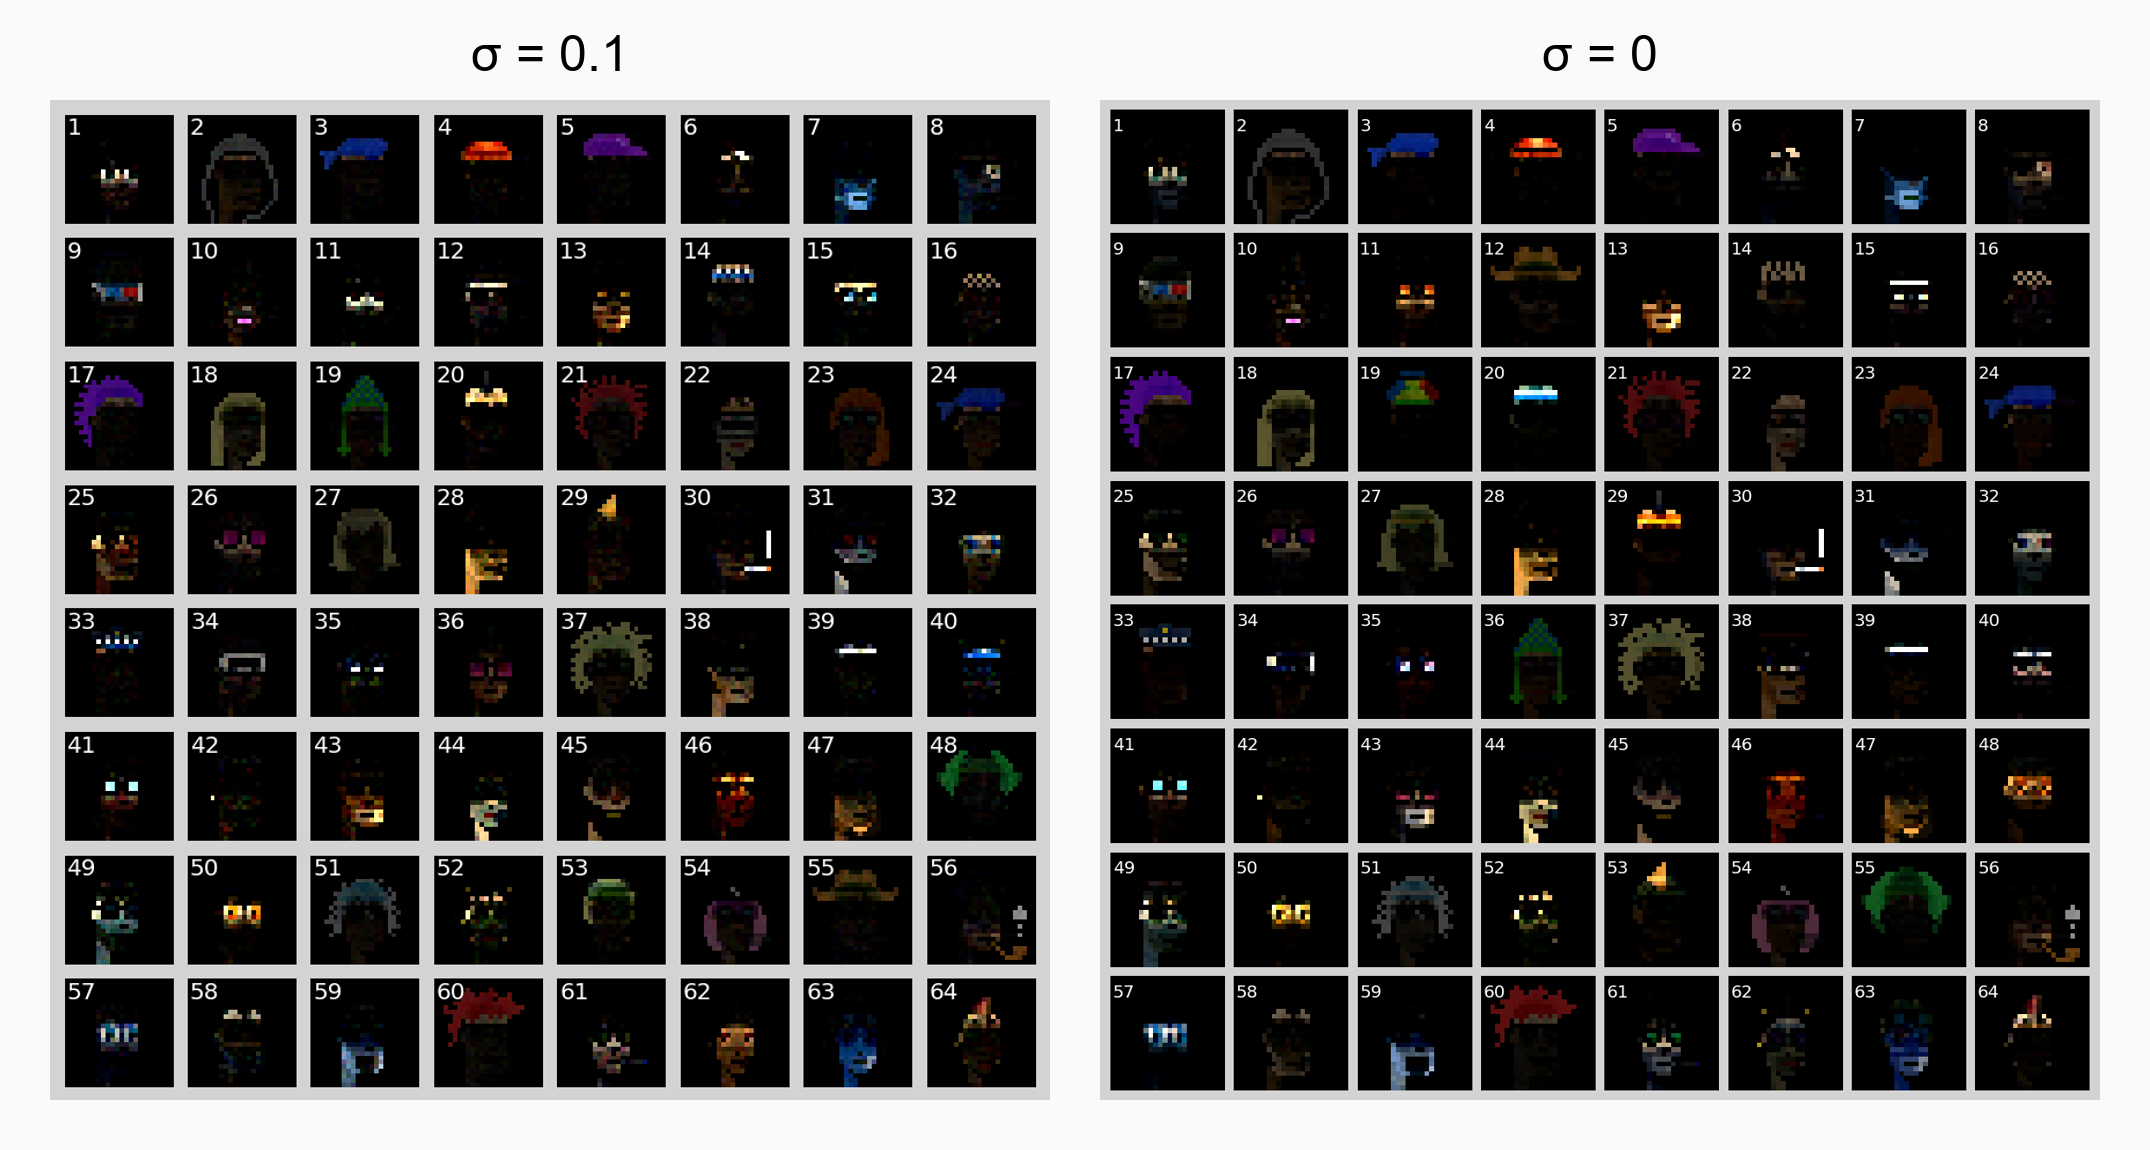
</div>

*Figure 12:* Columns of $W$ interpreted as RGB images, with and without noise, using $d=64$.

Comparing the columns of $W$ generated from the noisy and the noiseless images, we can see that they are quite similar. For most of the images there is not a noteworthy difference between the noisy and noiseless ones. Though there are some exceptions, like image 14, where the colors are clearly different, or image 36 where the columns seem to represent a completely different feature.


<a class="anchor" id="3d_reconstruction_comparison"></a>

<div>
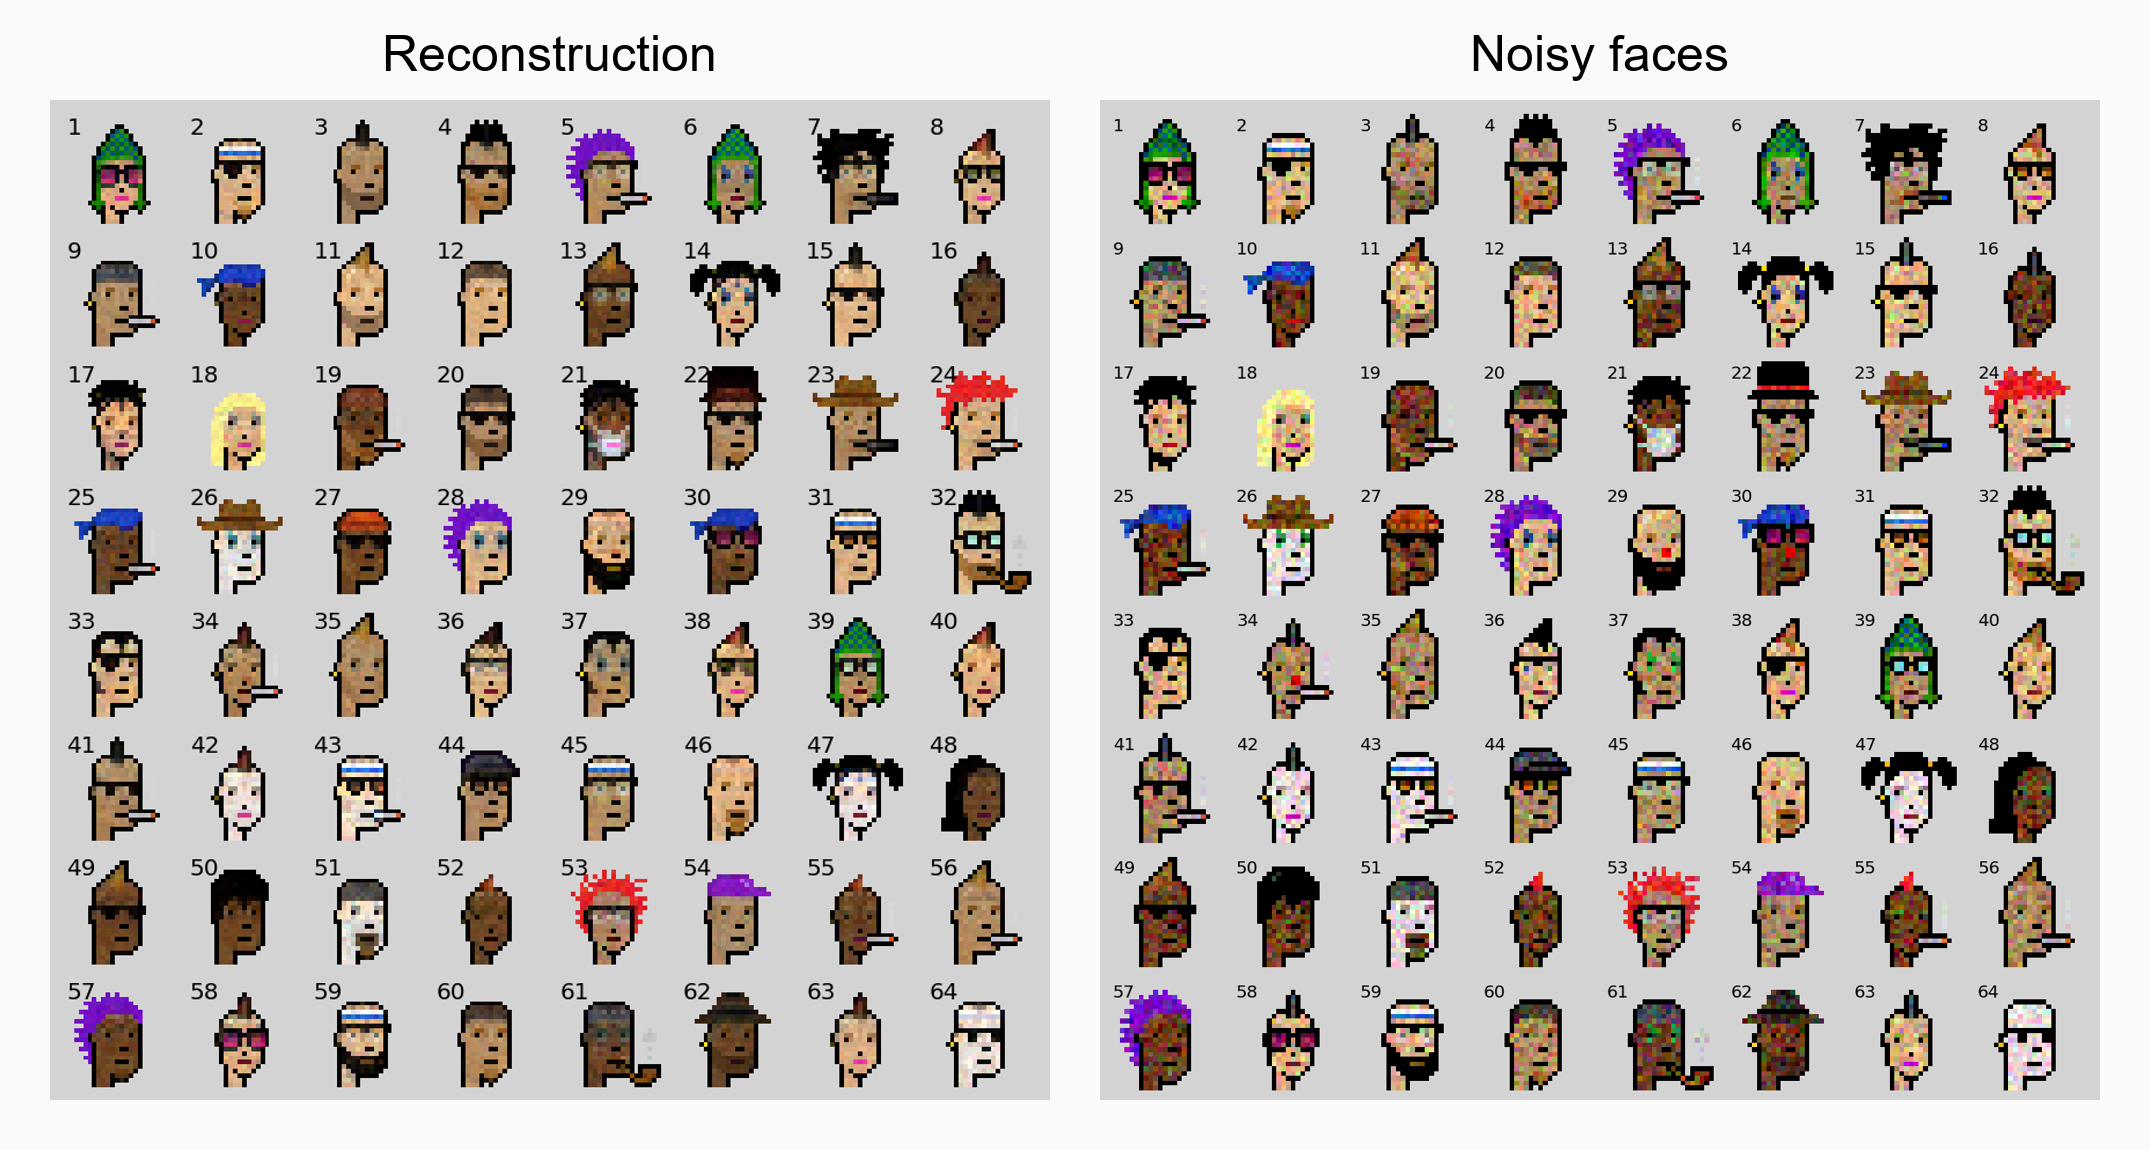
</div>


*Figure 13:* Noisy images and reconstructions, using $d=64$. We compare these to [noiseless reconstructions](#2d_reconstruction_comparison).

Looking at figure 13 it is clear to see that the reconstructed images contain way less noise than the noisy images. The noisy reconstructions are actually more similar the [noiseless reconstructions](#2d_reconstruction_comparison) from earlier. When comparing the two we can notice that there is slightly more miscoloring in the noisy reconstructions, but overall, they look very similar and represent the original images almost equally well.  



**The ideal d**

We will now do a slightly different experiment with the noisy images. If we had done the same analysis as previously, the difference between the noisy $A$, $A_n$, and the NMF, $WH$, would decrease as in [figure 9](#figure_9). Comparing the NMF with the original matrix $A$, however, we will (hopefully) find NMF's that are closer to $A$ than the original noisy matrix. This would mean that the details the NMF 'loses' for smaller values of $d$ corresponds to the noise, resulting in denoised images.


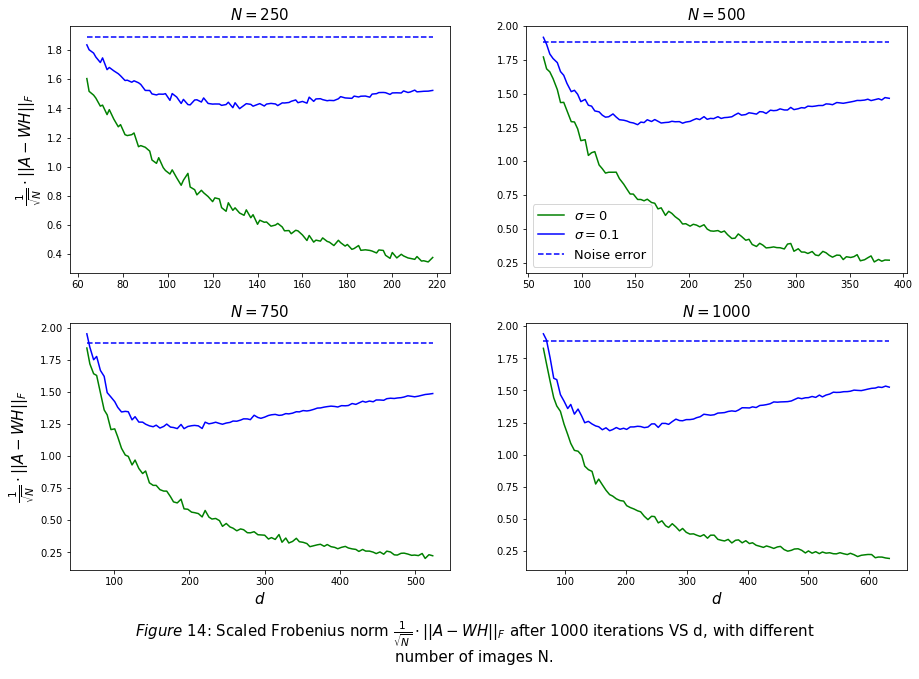

Lowest final error(N=250) = 1.4
Lowest final error(N=500) = 1.27
Lowest final error(N=750) = 1.22
Lowest final error(N=1000) = 1.19


In [20]:
def denoise_at_different_N_sim(N_vals, maxiter, noise_level, number_of_d, filetitle="denoise_at_diff_N"):
    """
    Performs NMF with and without noise for number_of_d d-values such that amount of data is reduced for N in N_vals. Stores 
    N_vals, maxiter, noise_level, d_val_arrays, final_errors, final_errors_noisy, initial_noise_errors in npz file.
    input:
        N_vals: list of N-values, where N is number of images to load
        maxiter: int, number of NMF iterations
        noise_level: float, max amplitude of noise
        number_of_d: int, number of feature numbers d to test
        filetitle: string, title of npz file for data storage
    output:
        none, data is saved to filetitle.npz
    """    
    # Initialize arrays for data storage
    d_val_arrays         = []
    final_errors         = []
    final_errors_noisy   = []
    initial_noise_errors = []
    
    for N in tqdm(N_vals):
        # We consider only d values that reduce the amount of data
        d_vals = np.linspace(64, np.floor(1728*N/(1728+N)), number_of_d, dtype = 'int')

        # Load, reshape and add noise to images
        faces_es                = load_images(N)
        faces_reshaped_es       = split_and_reshape(faces_es)[0] # only want color channels
        faces_reshaped_noisy_es = add_noise(faces_reshaped_es, noise_level)
        
        print(np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'fro')/N**(1/2))      
        print(np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'nuc')/N**(1/2))      
        
        # Initialise arrays for final errors
        final_error_es       = np.zeros(len(d_vals))
        final_error_noisy_es = np.zeros(len(d_vals))
    
        # Do NMF for all the d values
        for i in tqdm(range(len(d_vals)), leave = False):
            # NMF with noise removal
            W_n, H_n, err_n         = NMF(faces_reshaped_noisy_es, d_vals[i], maxiter=maxiter)
            final_error_noisy_es[i] = np.linalg.norm(faces_reshaped_es - np.dot(W_n, H_n), 'fro')

            # NMF without noise removal
            W, H, err         = NMF(faces_reshaped_es, d_vals[i], maxiter=maxiter)    
            final_error_es[i] = err[-1]
        
        # Add the errors to the final_errors
        d_val_arrays.append(d_vals)
        final_errors.append(final_error_es)
        final_errors_noisy.append(final_error_noisy_es)
        initial_noise_errors.append(np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'fro'))        
    
    # Save the data
    np.savez(filetitle, N_vals=N_vals, maxiter=maxiter, noise_level=noise_level, d_val_arrays=d_val_arrays, 
             final_errors=final_errors, final_errors_noisy=final_errors_noisy, initial_noise_errors=initial_noise_errors)
    
# We load N images, with N chosen from this array
N_vals      = [250, 500, 750, 1000]
maxiter     = 1000
noise_level = 0.1
number_of_d = 100

# Run the simulation at own risk, remove the overwrite protection "###"
# ###denoise_at_different_N_sim(N_vals, maxiter, noise_level, number_of_d, filetitle = "###denoise_at_diff_N")

data = np.load("denoise_at_diff_N.npz")
d_val_arrays       = data['d_val_arrays']
final_errors       = data['final_errors']
final_errors_noisy = data['final_errors_noisy']
initial_noise_errors = data['initial_noise_errors']

for i in range(4):
    final_errors[i] /= N_vals[i]**(1/2)
    final_errors_noisy[i] /= N_vals[i]**(1/2)
    initial_noise_errors[i] /= N_vals[i]**(1/2)

x_vals_list = [[d_val_arrays[i], d_val_arrays[i],       [d_val_arrays[i][0],      d_val_arrays[i][-1]]]     for i in range(4)]
y_vals_list = [[final_errors[i], final_errors_noisy[i], [initial_noise_errors[i], initial_noise_errors[i]]] for i in range(4)]
linestyles  = [["g", "b", "b--"] for i in range(4)]
fig_text    = r"$Figure$ 14: Scaled Frobenius norm $\frac{1}{\sqrt{N}}\cdot||A-WH||_F$ after 1000 iterations VS d, with different number of images N."

plot_function(x_vals_list, y_vals_list, linestyles, fig_size = (15, 10), shape = (2, 2),
        xlabels = ["", "", f"$d$", f"$d$"], ylabels=[r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$", "", r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$", ""],
        fig_text=fig_text, fig_text_size=15, fig_text_y = 0, titles = [f"$N=${N}" for N in N_vals], 
        labels = [False, [r"$\sigma=0$", r"$\sigma=0.1$", "Noise error"], False, False], loc = [False, "lower left", False, False])

for i in range(4):
    print(f"Lowest final error(N={N_vals[i]}) = {round(np.min(final_errors_noisy[i]), 2)}")


This plot was made with only one level of noise, $\sigma = 0.1$. The general discussion about the shape of the curves comes in the next markdown box. Observe first, however, that the ideal value of $d$, or rather the value of $d$ that gives the best denoised version of $A$, is approximately the same for all the different values of $N$. Particularly, for $N \geq 500$, the curves look almost identical. This would suggest that $N=500$ images is sufficient to capture the most important features of the dataset.


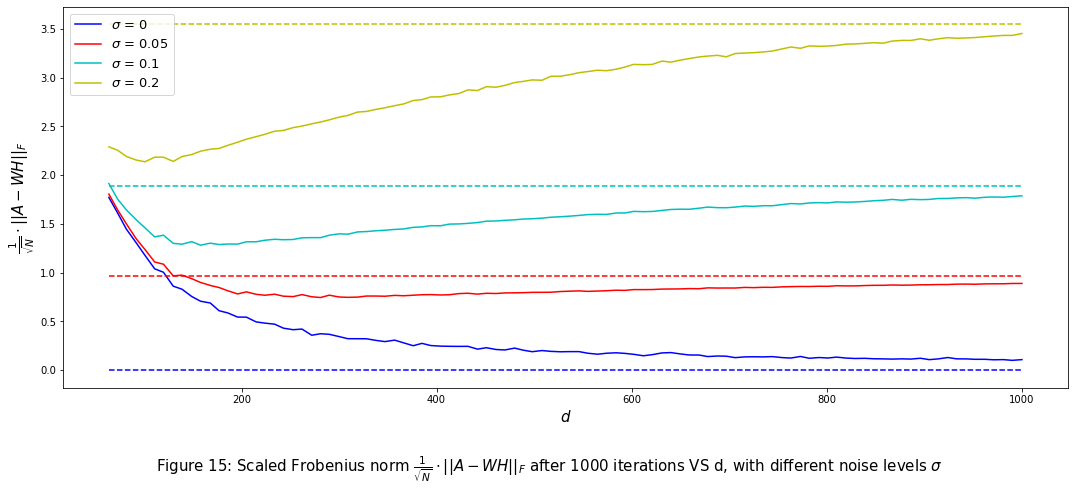

In [21]:
def denoise_at_different_noise_lvl_sim(noise_levels, maxiter, d_vals, N=500, filetitle="denoise_at_diff_noise"):
    """
    Performs NMF at different noise levels. Stores N, maxiter, noise_levels, d_vals, final_errors_noisy, 
    initial_noise_errors in npz file.
    input:
        noise_levels: list of noise levels
        maxiter: int, number of NMF iterations
        d_vals: np.array of d values for NMF
        N: number of images to load
        filetitle: string, title of npz file for data storage
    output:
        none, data is saved to filetitle.npz
    """    
    # Load and reshape N images 
    faces_es          = load_images(N)
    faces_reshaped_es = split_and_reshape(faces_es)[0]
    
    # Initialize lists for errors
    final_errors_noisy   = []
    initial_noise_errors = []
    
    # Do NMF for each noise level
    for noise_level in tqdm(noise_levels, leave=False):
        # Add noise to images
        faces_reshaped_noisy_es = add_noise(faces_reshaped_es, noise_level)

        # Initialise arrays for final errors
        final_err = np.zeros(len(d_vals))

        # Do NMF algorithm for each d-value
        for index, d_val in tqdm(enumerate((d_vals)), total = len(d_vals), leave=False):
            W, H, err    = NMF(faces_reshaped_noisy_es, d_val, maxiter = maxiter)
            final_err[index] = np.linalg.norm(faces_reshaped_es - np.dot(W, H), 'fro')

        # Add values
        final_errors_noisy.append(final_err)
        initial_noise_err = np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'fro')
        initial_noise_errors.append(initial_noise_err)
        
        # Save and plot 
        np.savez(f"denoise_at_sigma={noise_level}", N=N, maxiter=maxiter, noise_level=noise_level, d_vals=d_vals, 
                 final_err=final_err, initial_noise_err=initial_noise_err)
        plt.plot(d_vals, final_err)
        plt.axhline(y=initial_noise_err)
        plt.show()

        
    # SAVE DATA
    np.savez(filetitle, N=N, maxiter=maxiter, noise_levels=noise_levels, d_vals=d_vals, 
             final_errors_noisy=final_errors_noisy, initial_noise_errors=initial_noise_errors)
    
# Set parametres
noise_levels = [0, 0.05, 0.1, 0.2]
maxiter      = 1000
d_vals       = np.linspace(64, 1000, 100, dtype='int')

# Repeat simulation at own risk
# ###denoise_at_different_noise_lvl_sim(noise_levels, maxiter, d_vals, N=500, filetitle="###denoise_at_diff_noise.npz")
    
# Load data
data = np.load("denoise_at_diff_noise.npz")
        
x_vals_list = [data['d_vals'] for noise in noise_levels]
y_vals_list = [data['final_errors_noisy'][i]/np.sqrt(500) for i in range(len(noise_levels))]
labels      = []
for i, noise_level in enumerate(noise_levels):
    x_vals_list.append([data['d_vals'][0],                            data['d_vals'][-1]])
    y_vals_list.append([data['initial_noise_errors'][i]/np.sqrt(500), data['initial_noise_errors'][i]/np.sqrt(500)])
    labels.append(r"$\sigma$ = " + f"{noise_level}")
    
linestyles  = [["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:blue--", "tab:orange--", "tab:green--", "tab:purple--"]]
linestyles  = [["b", "r", "c", "y", "b--", "r--", "c--", "y--"]]

fig_text    = r"Figure 15: Scaled Frobenius norm $\frac{1}{\sqrt{N}}\cdot||A-WH||_F$ after 1000 iterations VS d, with different noise levels $\sigma$"

plot_function([x_vals_list], [y_vals_list], linestyles, fig_size=(18, 7),
        xlabels=[f"$d$"], ylabels=[r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$"],
        fig_text=fig_text, fig_text_y=-0.04, labels=[labels],
        loc = [False, "lower left", False, False])


The simulation for different values of noise (characterized by the value $\sigma$), can be seen in figure 15. The horizontal dotted lines are the Frobenius differences between the original matrix and the different noisy matrices.

Why the algorithm works, and why the graphs are shaped the way they are can, at least partially, be explained with the terms underfitting and overfitting. The phenomena of underfitting and overfitting are major concerns in the field of machine learning and can be explained with a classic example from machine learning. Say you would like to create an algorithm that can recognize handwritten digits. To do this, you can use a neural network combined with a very large dataset. The neural network works as a function approximator, that approximates the function image -> digit using the dataset.

Underfitting happens when the dataset or the number of training epochs over the dataset is too small. With too little information, the neural network cannot approximate the real (and rather complex) function of digit recognition, as the nuances of the problem hasn't manifested themselves yet. This is like trying to discern a non-linear relationship between two parameters, having only two datapoints. Too little information results in a function approximation of a simpler function, leading to large errors.

Overfitting on the other hand, happens when the neural network trains too much on the same dataset. The function approximation will then begin to consider the individual aspects of the images, rather than the general notion of what a digit is. The neural network would be able to predict almost perfectly which numbers the dataset corresponds to but has now learned features of numbers that are specific to the dataset, and not features of general numbers. This, too, results in large errors.

When the above algorithm reconstructs the noisy images with a low value of $d$, the drastically smaller amount of information leads to underfitting, with corresponding large errors. Underfitting is even more predominant than the noise itself, as can be seen by comparing the values on the graph towards the left with the horizontal lines. It is therefore necessary to increase the $d$ to get a good reconstruction of $A$. 

Too large a value of $d$ will, however, result in columns of $W$ corresponding to features specific to the noisy images, rather than general features of faces. The noisy images do still have features like 'eye placement' and 'hair color', but they will also have features originating from the added noise. The clue, then, is to increase the value of $d$ until the features in $W$ corresponds to general features of the faces, and stop before the features that are specific to the noisy dataset (i.e. the noise) are added. 

These effects results in large errors for small $d$, and large errors for large $d$. It makes sense therefore, that the graph has a critical value of $d$ with the smallest Frobenius-difference with the noiseless image $A$. From figure 14, it seems $d \approx 150$ gives the best denoising. From figure 15, it is also clear that more noisy images need a smaller value of $d$, which is reasonable.


## Conclusion <a class="anchor" id="conclusion"></a>

We've shown that the CryptoPunk dataset is highly, in lack of a better term, 'featurized' in the sense that almost every image can be viewed as a linear combination of specific features. Consider, as an example, image nr 5 of the blue haired guy with reading glasses who has a cigarette in his mouth. This image can be written as a mere additive combination of these features. If the position of the eyes or the relative position of the head changed from image to image, this linear combination wouldn't work. The images being centered and the eyes appearing in the same pixel-positions are therefore very important if NMF is going to work. As a result of this, NMF is not the approach one should take when solving a nonlinear problem like handwriting recognition. With linear problems, however, the approach has shown itself to be powerful and effective. 

One major advantage of imposing non-negativity to the standard SVD optimization problem, is the ability to analyze and understand the workings of the algorithm in a graphical way. Non-negativity makes it possible to interpret the matrices (or rather the columns of the matrices) as images themselves, yielding truly interesting and rather beautiful images like [figure 4](#W_columns). Mathematically and algorithmically being able to decompose images into 'eigenvectors' like these gives further insight into the datasets, and the inner workings of the algorithm, in a way that humans can understand. This insight is difficult (and often impossible) to get from nonlinear approaches like neural networks.

NMF also works quite well as a denoising algorithm. Noise is, in its nature, random and therefore full of information. Decomposing an image into its features can, in some sense, be regarded as compression. It isn't possible to compress truly noisy data without loss. However, noise is almost always unwanted. If the information that is lost when trying to compress the data is random noise, and not general features or wanted aspects of the images, the compression may be practical and useful. When the underlying features of the images are linear, in such a way that NMF can be applied, it is therefore not too suprising that NMF can denoise images quite proficiently. NMF doesn't reproduce noise, because it would need many 'eigenvectors' and many weights to accurately describe true noise. 
<!--  -->
With this we conclude our discussion of the Non-negative Matrix Factorization.
